In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [102]:
import numpy as np
import pandas as pd
import pickle as pkl
import lmfit as lm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook

from configs import (
    femmfile_75_1006,
    Hall_currents,
    pkl_interp_fcn_Hall,
    pkl_interp_fcn_NMR,
    pklfit_stable_temp,
    pklfit_temp_hall,
    pklfit_temp_nmr,
    pklinfo_hall_regress,
    pklinfo_nmr_regress,
    pklinfo,
    pklproc,
    pklproc_hyst,
    pklproc_ramp,
    pklraw,
    probe,
)
# from model_funcs import mod_lin, mod_lin_alt, ndeg_poly
from preprocess_data import get_probe_IDs
from GMW_excitation_data import df_GMW
from plotting import config_plots, get_label#, datetime_plt
config_plots()
from factory_funcs import get_NMR_B_at_T0_func, get_Hall_B_at_T0_func
from femm_fits import load_data

# FEMM Step Size Check

In [104]:
df_hall, df_hall_meas, df_nmr, df_nmr_meas = load_data(femmfile_75_1006, Hall_currents)

In [105]:
df_hall

probe    I  Br        Bz         B
0    Hall    0   0  0.000000  0.000000
1    Hall    2   0  0.012025  0.012025
2    Hall    4   0  0.024050  0.024050
3    Hall    6   0  0.036075  0.036075
4    Hall    8   0  0.048100  0.048100
..    ...  ...  ..       ...       ...
136  Hall  272   0  1.391482  1.391482
137  Hall  274   0  1.395886  1.395886
138  Hall  276   0  1.400187  1.400187
139  Hall  278   0  1.404391  1.404391
140  Hall  280   0  1.408504  1.408504

[141 rows x 5 columns]

# Temperature Check

In [65]:
df_proc = pd.read_pickle(pklproc)
df_raw = pd.read_pickle(pklraw)

In [97]:
for c in df_raw.columns:
    if ("ICW" in c) or ("LCW" in c):
        print(c)

LCW in Coil1
LCW out Coil 1
LCW in Coil 2
LCW out Coil 2
LCW to PS
LCW in barrel
ICW in
ICW HE1 out
ICW He2 out
LCW return magnet
LCW to barrel
LCW from PS
LCW to magnet


In [ ]:
df_

In [66]:
probe

'6A0000000D61333A'

In [87]:
# t0 = '2021-02-24 09:49:00'
# tf = '2021-02-25 10:36:00'
t0 = '2021-02-24 09:57:00'
tf = '2021-02-25 10:35:00'
df_ = df_raw.query(f'"{t0}" < index < "{tf}"').copy()
df_ = df_.query('`NMR [T]` > 0.1').copy()

In [81]:
#i = 23 # 7
#df_ = df_proc.query(f'run_num == {i}').copy()

In [88]:
df_['NMR [T]'].describe()

count    1477.000000
mean        1.208777
std         0.000044
min         1.208747
25%         1.208750
50%         1.208755
75%         1.208784
max         1.208929
Name: NMR [T], dtype: float64

<IPython.core.display.Javascript object>


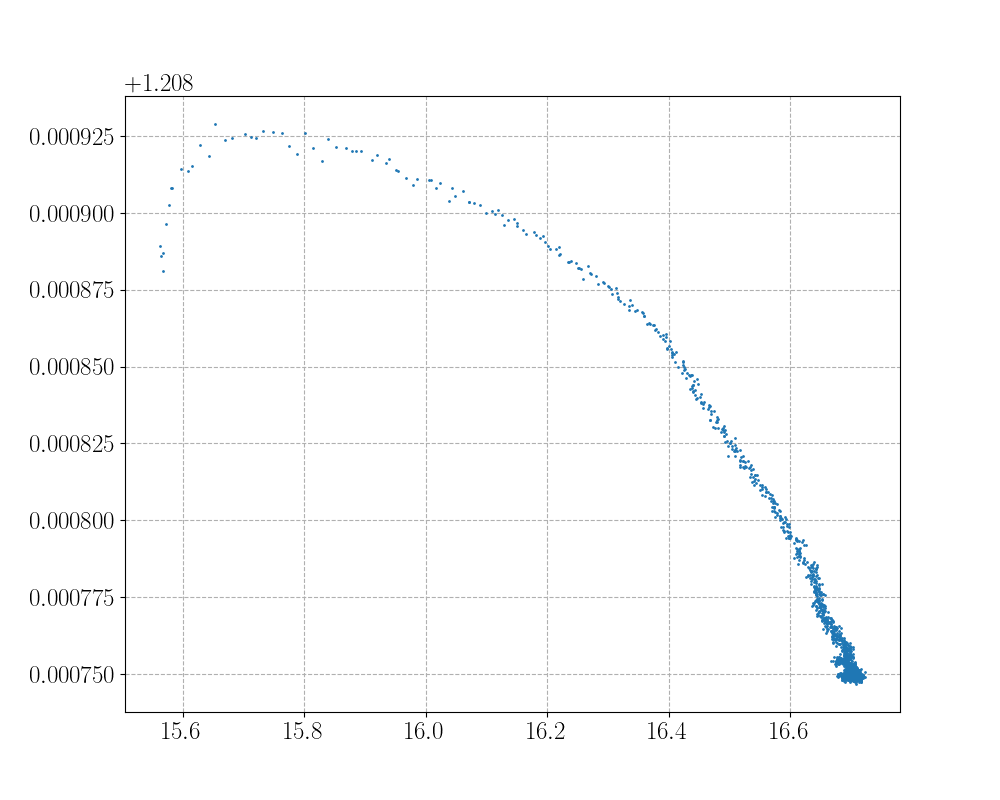

In [89]:
fig, ax = plt.subplots()
# ax.scatter(df_[f'{probe}_Cal_T'], df_[f'{probe}_Raw_Bmag'], s=1)
ax.scatter(df_[f'{probe}_Cal_T'], df_[f'NMR [T]'], s=1)

In [90]:
df_['NMR [T]'].max() - df_['NMR [T]'].min()

0.000182236999999974

<IPython.core.display.Javascript object>


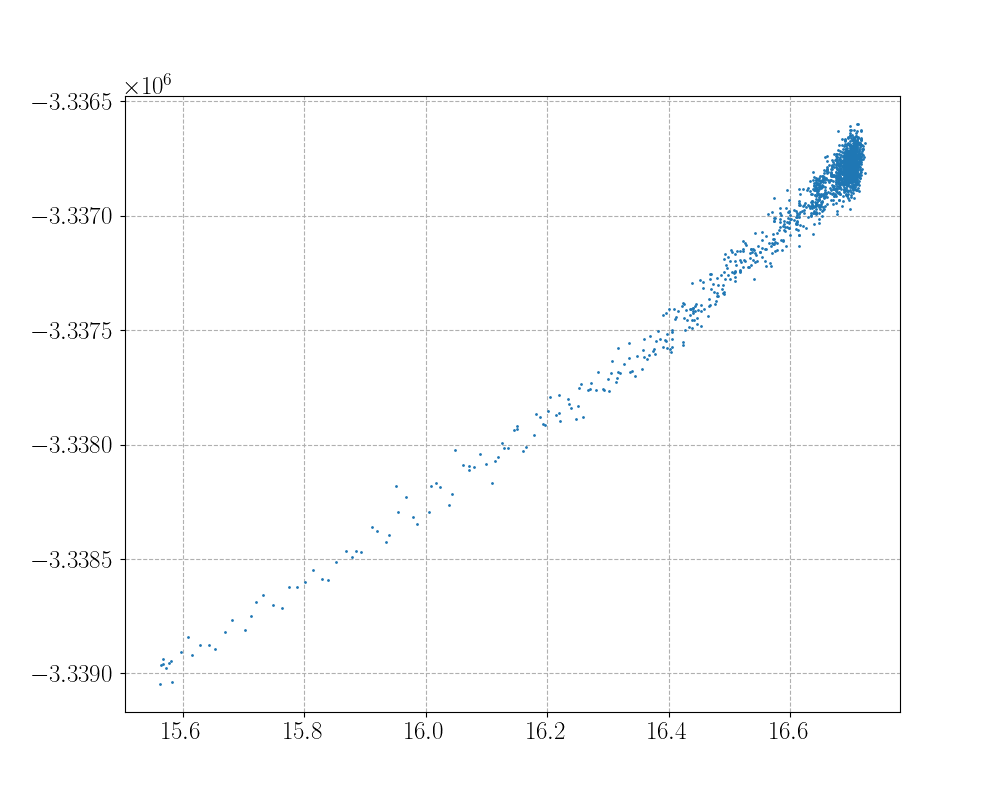

In [91]:
fig, ax = plt.subplots()
# ax.scatter(df_[f'{probe}_Cal_T'], df_[f'{probe}_Raw_Bmag'], s=1)
ax.scatter(df_[f'{probe}_Cal_T'], df_[f'{probe}_Raw_Z'], s=1)

In [58]:
(2.4818e6-2.4808e6)* (1/2.74604495e6) # Tesla / microvolt

0.0003641600986903

In [62]:
df_['NMR [T]'].max() - df_['NMR [T]'].min()

8.465299999993459e-05

In [63]:
3.6416/.84653

4.301796746718958

<IPython.core.display.Javascript object>


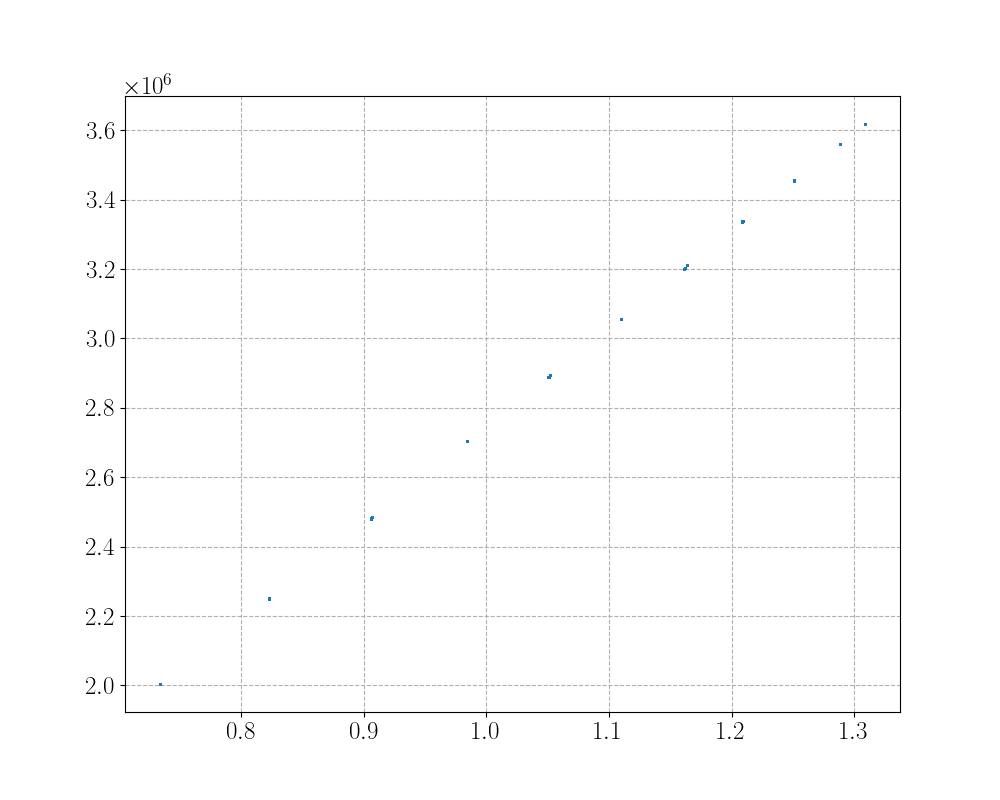

In [8]:
df_ = df_proc.query('`Magnet Current [A]` > 125.').copy()

fig, ax = plt.subplots()
ax.scatter(df_['NMR [T]'], df_[f'{probe}_Raw_Bmag'], s=1)

In [46]:
df_ = df_proc.query('(`Magnet Current [A]` > 125.)').copy()
#df_ = df_proc.query('(`Magnet Current [A]` > 125.) & (run_num <= 18)').copy()

In [47]:
def lin(B, **params):
    return params['C0'] + params['C1'] * B

def quad(B, **params):
    return params['C0'] + params['C1'] * B + params['C2'] * B**2

In [50]:
# model = lm.Model(lin, independent_vars=['B'])
model = lm.Model(quad, independent_vars=['B'])
params = lm.Parameters()
params.add('C0', value=0, vary=False)
params.add('C1', value=2.6e6, vary=True)
params.add('C2', value=0, vary=False)
results = model.fit(df_[f'{probe}_Raw_Bmag'].values, B=df_['NMR [T]'].values, params=params,
                    weights= 1/(3e-5 * df_[f'{probe}_Raw_Bmag'].values))
# results = model.fit(df_[f'{probe}_Raw_Bmag'].values, B=df_['NMR [T]'].values, params=params,
#                     weights= 1/(3e-5 * np.ones_like(df_[f'{probe}_Raw_Bmag'].values)))

In [51]:
results

In [54]:
2.74604495e6 # microvolt / Tesla

2746044.95

In [56]:
(1/2.74604495e6) # Tesla / microvolt

3.641600986903e-07

<IPython.core.display.Javascript object>


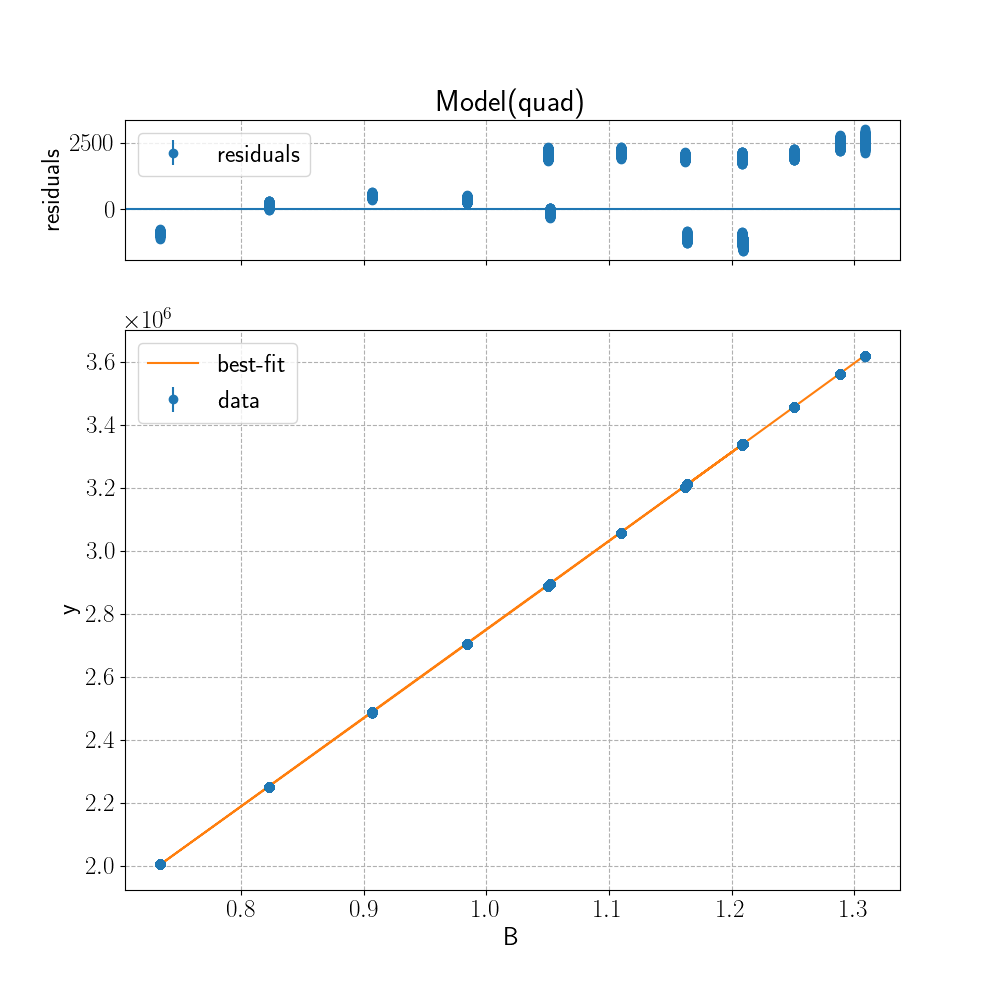

(<Figure size 1000x1000 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

In [43]:
results.plot()

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes((0.12, 0.3, 0.7, 0.6))
ax2 = fig.add_axes((0.12, 0.08, 0.7, 0.185))
# colorbar axis
cb_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# plot data and fit
# data
# with errorbars
#if ystd_sf == 1:
#    label_data = 'Data'
#else:
#    label_data = r'Data (error $\times$'+f'{ystd_sf})'
label_data = 'Data'
ax1.errorbar(df_[xcol].values, df_[ycol].values, yerr=ystd_sf*ystd,
             fmt='o', ls='none', ms=2, zorder=100, label=label_data)
# scatter with color
#sc = ax1.scatter(df_[xcol].values, df_[ycol].values, c=df_.index, s=1,
#                 zorder=101)
sc = ax1.scatter(df_[xcol].values, df_[ycol].values, c=df_.run_hours, s=1,
                 zorder=101)
# fit
ax1.plot(df_[xcol].values, result.best_fit, linewidth=2, color='red',
         zorder=99, label=label)
# calculate residual (data - fit)
res = df_[ycol].values - result.best_fit
# calculate ylimit for ax2
yl = 1.1*(np.max(np.abs(res)) + ystd_sf*ystd[0])
# plot residual
# zero-line
xmin = np.min(df_[xcol].values)
xmax = np.max(df_[xcol].values)
ax2.plot([xmin, xmax], [0, 0], 'k--', linewidth=2, zorder=98)
# residual
ax2.errorbar(df_[xcol].values, res, yerr=ystd_sf*ystd, fmt='o', ls='none',
             ms=2, zorder=99)
#ax2.scatter(df_[xcol].values, res, c=df_.index, s=1, zorder=101)
ax2.scatter(df_[xcol].values, res, c=df_.run_hours, s=1, zorder=101)
# colorbar for ax1
cb = fig.colorbar(sc, cax=cb_ax)
cb.set_label('Time [Hours]')
if ycol == 'NMR [T]':
    ylabel1 = r'$|B|_\mathrm{NMR}$ [T]'
    title_prefix = 'NMR'
else:
    ylabel1 = r'$|B|_\mathrm{Hall}$ [T]'
    title_prefix = 'Hall Probe'
# set ylimit ax2
ax2.set_ylim([-yl, yl])
# remove ticklabels for ax1 xaxis
ax1.set_xticklabels([])
# axis labels
ax2.set_xlabel(r'Yoke (center magnet) Temp. [$^{\circ}$C]')
ax2.set_ylabel('(Data - Fit) [T]')
ax1.set_ylabel(ylabel1)
# force consistent x axis range for ax1 and ax2
tmin = np.min(df_[xcol].values)
tmax = np.max(df_[xcol].values)
range_t = tmax-tmin
ax1.set_xlim([tmin-0.1*range_t, tmax+0.1*range_t])
ax2.set_xlim([tmin-0.1*range_t, tmax+0.1*range_t])
# turn on legend
ax1.legend().set_zorder(102)
# add title
fig.suptitle(f'{title_prefix} vs. Temperature Regression: Linear Model\n'+
             f'Run Index {run_num}')
# minor ticks
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax1.tick_params(which='both', direction='in', top=True, right=True,
                bottom=True)
ax2.tick_params(which='both', direction='in', top=True, right=True)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df_['NMR [T]'], df_[f'{probe}_Raw_Bmag'], s=1)

<IPython.core.display.Javascript object>


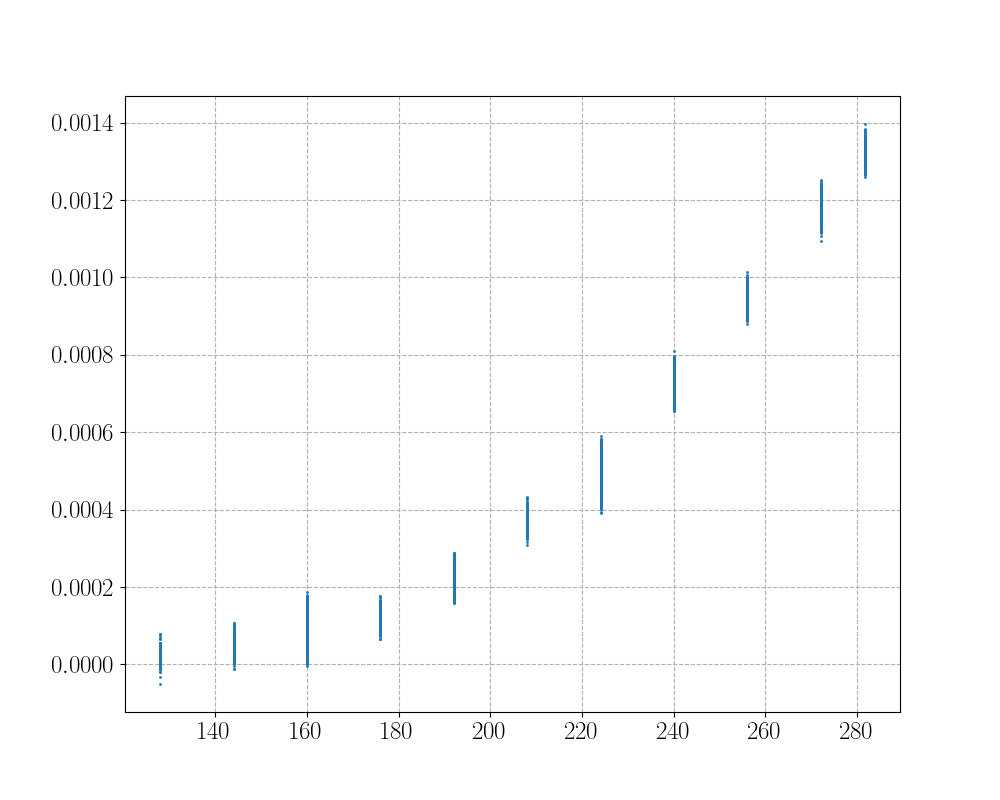

In [7]:
df_ = df_proc.query('`Magnet Current [A]` > 125.').copy()

fig, ax = plt.subplots()
ax.scatter(df_['Magnet Current [A]'], df_['NMR [T]']-df_[f'{probe}_Cal_Bmag'], s=1)

In [4]:
probes = get_probe_IDs(df_proc)

In [526]:
probes

['6A0000000D61333A',
 'C50000000D5E473A',
 'C90000000D53983A',
 'DF0000000D5E803A']

In [533]:
df_ = df_proc.copy()
# df_ = df_proc.query('run_num < 3').copy()

<IPython.core.display.Javascript object>


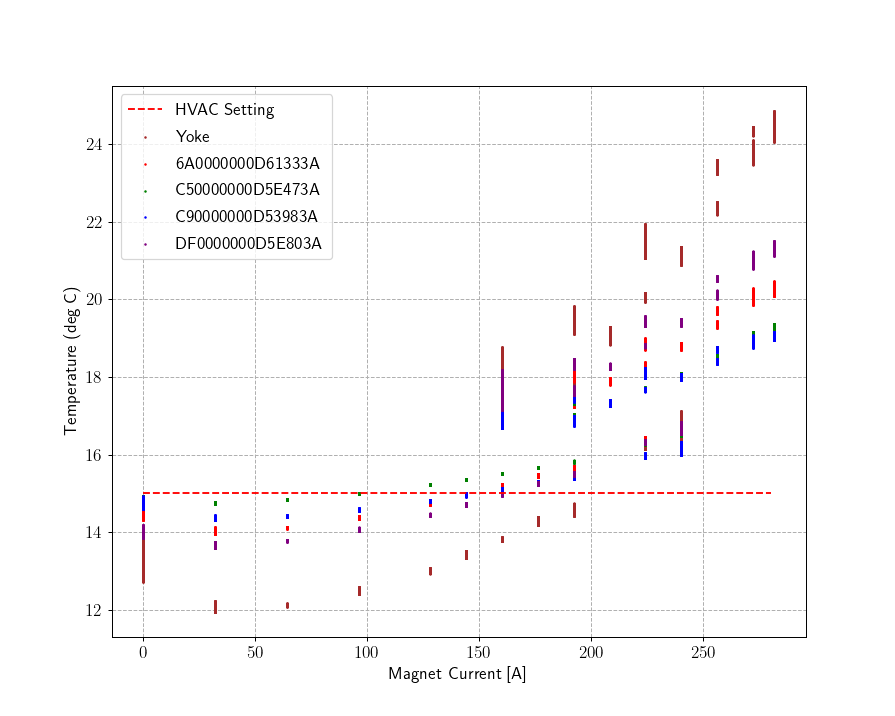

In [534]:
fig, ax = plt.subplots()
ax.scatter(df_['Magnet Current [A]'], df_['Yoke (center magnet)'], s=1, c='brown', label='Yoke')
for p, c in zip(probes, ['red', 'green', 'blue', 'purple']):
    ax.scatter(df_['Magnet Current [A]'], df_[f'{p}_Cal_T'], s=1, c=c, label=p)

ax.plot([0, 280], [15,15], 'r--', label='HVAC Setting')
ax.set_xlabel('Magnet Current [A]')
ax.set_ylabel('Temperature (deg C)')
ax.legend();

In [468]:
df_ = df_proc.query('run_num == 3').copy()

In [469]:
df_['Roof'].describe()

count    207.000000
mean      14.940302
std        0.005055
min       14.927125
25%       14.936987
50%       14.940301
75%       14.943987
max       14.950712
Name: Roof, dtype: float64

In [471]:
0.0006 * 12

0.0072

# Chi2

In [512]:
results_stable = pkl.load(open(pklfit_stable_temp, 'rb'))

In [519]:
results_nmr = pkl.load(open(pklfit_temp_nmr, 'rb'))

In [485]:
len(results_stable[0].data)-len(results_stable[0].var_names)

1476

In [486]:
results_stable[0]

In [479]:
from scipy.stats import chi2

In [502]:
dof = len(results_stable[1].data)-len(results_stable[1].var_names)

In [503]:
chi2_ = results_stable[1].chisqr

In [504]:
chi2_

540.216719389894

In [505]:
dof

1509

In [506]:
chi2.pdf(1300, df=dof)

2.875740091931071e-06

In [507]:
chi2.sf(chi2_, df=dof)

1.0

In [520]:
rchi = []
pchi2 = []
# for key, res in sorted(results_stable.items()):
for key, res in sorted(results_nmr.items()):
#     print(res.redchi)
    rchi_ = res.redchi
    rchi.append(rchi_)
    # pchi2
    chi2_ = res.chisqr
    dof = len(res.data)-len(res.var_names)
    chi2_ = res.chisqr
    pchi2_ = chi2.sf(chi2_, df=dof)
    pchi2.append(pchi2_)
rchi = np.array(rchi)
pchi2 = np.array(pchi2)

In [521]:
pchi2

array([9.99999882e-001, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00896411e-004, 6.34090072e-022,
       1.99343464e-035, 0.00000000e+000, 1.78757771e-250, 1.68876612e-300,
       6.94705653e-212, 0.00000000e+000, 9.77219304e-001, 0.00000000e+000])

<IPython.core.display.Javascript object>


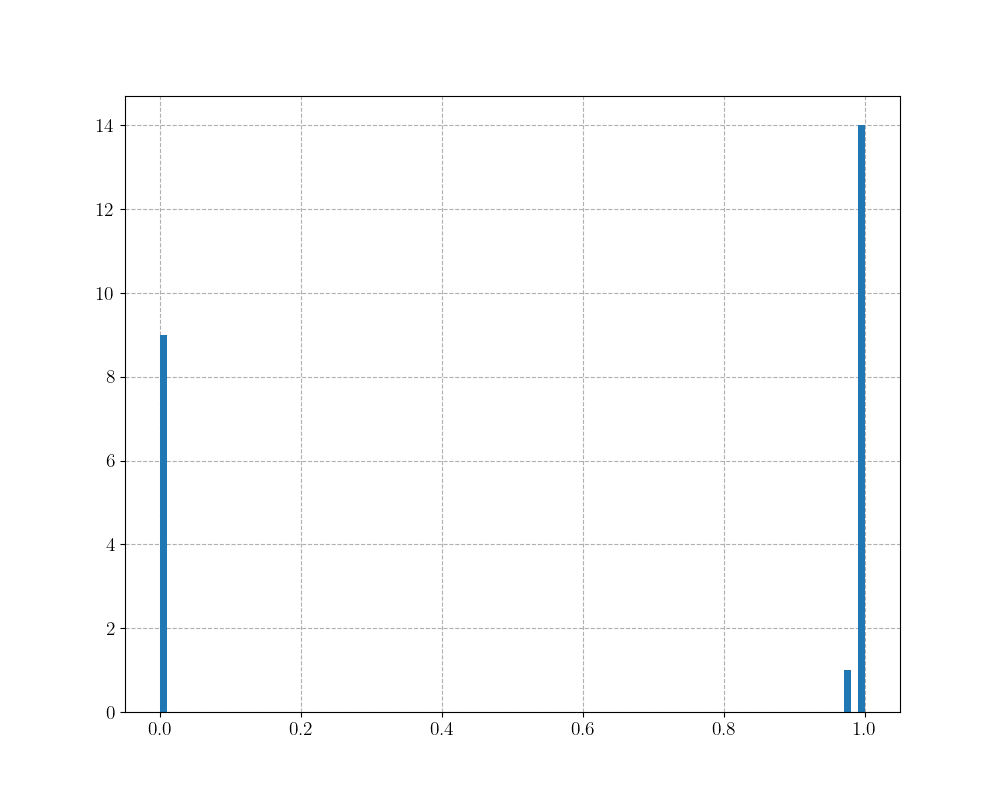

(array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 14.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

In [522]:
fig, ax = plt.subplots()
ax.hist(pchi2, bins=100)

# String Manipulations

In [411]:
param='A'
results_nmr[0].params[param].value

1.2104263917311395

In [415]:
results_nmr

{0: <lmfit.model.ModelResult at 0x7faa911b6910>,
 1: <lmfit.model.ModelResult at 0x7faa9118fe50>,
 2: <lmfit.model.ModelResult at 0x7faa911528b0>,
 3: <lmfit.model.ModelResult at 0x7faa911968b0>,
 4: <lmfit.model.ModelResult at 0x7faa9113e0a0>,
 5: <lmfit.model.ModelResult at 0x7faa911535b0>,
 6: <lmfit.model.ModelResult at 0x7faa91153c70>,
 7: <lmfit.model.ModelResult at 0x7faa9117d940>,
 8: <lmfit.model.ModelResult at 0x7faa911d5ac0>,
 9: <lmfit.model.ModelResult at 0x7faa911d5070>,
 10: <lmfit.model.ModelResult at 0x7faa911ae250>,
 11: <lmfit.model.ModelResult at 0x7faa911b0b50>,
 12: <lmfit.model.ModelResult at 0x7faa9115e0a0>,
 13: <lmfit.model.ModelResult at 0x7faa91164820>,
 14: <lmfit.model.ModelResult at 0x7faa9116aa30>,
 15: <lmfit.model.ModelResult at 0x7faa9116cd60>,
 16: <lmfit.model.ModelResult at 0x7faa9116fe50>,
 17: <lmfit.model.ModelResult at 0x7faa91170e20>,
 18: <lmfit.model.ModelResult at 0x7faa911a1f10>,
 19: <lmfit.model.ModelResult at 0x7faa911a5f10>,
 20: <lmfi

In [417]:
for k,r in sorted(results_nmr.items()):
    print(k, r)

0 <lmfit.model.ModelResult object at 0x7faa911b6910>
1 <lmfit.model.ModelResult object at 0x7faa9118fe50>
2 <lmfit.model.ModelResult object at 0x7faa911528b0>
3 <lmfit.model.ModelResult object at 0x7faa911968b0>
4 <lmfit.model.ModelResult object at 0x7faa9113e0a0>
5 <lmfit.model.ModelResult object at 0x7faa911535b0>
6 <lmfit.model.ModelResult object at 0x7faa91153c70>
7 <lmfit.model.ModelResult object at 0x7faa9117d940>
8 <lmfit.model.ModelResult object at 0x7faa911d5ac0>
9 <lmfit.model.ModelResult object at 0x7faa911d5070>
10 <lmfit.model.ModelResult object at 0x7faa911ae250>
11 <lmfit.model.ModelResult object at 0x7faa911b0b50>
12 <lmfit.model.ModelResult object at 0x7faa9115e0a0>
13 <lmfit.model.ModelResult object at 0x7faa91164820>
14 <lmfit.model.ModelResult object at 0x7faa9116aa30>
15 <lmfit.model.ModelResult object at 0x7faa9116cd60>
16 <lmfit.model.ModelResult object at 0x7faa9116fe50>
17 <lmfit.model.ModelResult object at 0x7faa91170e20>
18 <lmfit.model.ModelResult object at 

In [429]:
_ = np.nan * np.ones(10)
#_[_==np.nan] = 0
_[np.isnan(_)] = 0
_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [434]:
df_info['run_num'] = df_info.index

In [435]:
df_info.run_num

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
Name: run_num, dtype: int64

In [445]:
f'{1.2:0.0f}'

'1'

In [436]:
df_info.columns

Index(['t0', 'tf', 'ramp', 'hyst', 'adc', 'chiller', 'NMR', 'B_NMR', 'I',
       'hours_data', 'num_meas', 'run_num'],
      dtype='object')

In [439]:
df_info.query('hyst')

t0                   tf   ramp  hyst      adc  chiller  \
0   2021-02-24 09:57:00  2021-02-25 10:35:45  False  True  750,000     True   
1   2021-02-25 10:36:15  2021-02-26 11:47:45  False  True  700,000     True   
2   2021-02-26 11:53:00  2021-03-01 09:12:45  False  True  750,000     True   
9   2021-03-04 09:14:45  2021-03-04 16:49:45   True  True  500,000     True   
11  2021-03-05 09:29:45  2021-03-05 14:00:00   True  True  600,000     True   
12  2021-03-08 07:50:45  2021-03-08 17:36:00   True  True  600,000    False   
14  2021-03-09 09:17:00  2021-03-09 17:33:00   True  True  700,000    False   
15  2021-03-09 17:37:00  2021-03-10 09:05:00   True  True  750,000    False   
16  2021-03-10 09:07:45  2021-03-10 18:34:00   True  True  800,000    False   
17  2021-03-10 18:37:45  2021-03-11 09:57:00   True  True  850,000    False   
19  2021-03-11 17:56:00  2021-03-12 09:20:00  False  True  850,000    False   
20  2021-03-12 09:23:45  2021-03-12 18:33:00  False  True  800,000    False   
21  2021-03-12 18:36:45  2021-03-15 17:27:00  False  True  700,000    False   
22  2021-03-15 17:33:45  2021-03-16 09:49:00  False  True  600,000    False   
23  2021-03-16 09:52:45  2021-04-05 08:09:15  False  True  500,000    False   

     NMR     B_NMR           I  hours_data  num_meas  run_num  
0   True  1.207960  240.069467   24.645833      1479        0  
1   True  1.158911  224.065923   25.191667      1512        1  
2   True  1.208438  240.069009   69.329167      4161        2  
9   True  0.906698  160.047885    7.583333       456        9  
11  True  1.039757  192.056063    4.504167       271       11  
12  True  1.044941  192.056237    9.754167       586       12  
14  True  1.151746  224.065366    8.266667       496       14  
15  True  1.208615  240.068824   15.466667       929       15  
16  True  1.248891  256.071131    9.437500       567       16  
17  True  1.285747  272.075589   15.320833       920       17  
19  True  1.288388  272.075324   15.400000       924       19  
20  True  1.248529  256.070678    9.154167       550       20  
21  True  1.159084  224.064884   70.837500      4191       21  
22  True  1.049826  192.055609   16.254167       976       22  
23  True  0.905710  160.047416  478.275000     28697       23

In [437]:
df_info['B_NMR']

0     1.207960
1     1.158911
2     1.208438
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.732467
8     0.821564
9     0.906698
10    0.981974
11    1.039757
12    1.044941
13    1.109522
14    1.151746
15    1.208615
16    1.248891
17    1.285747
18    1.302796
19    1.288388
20    1.248529
21    1.159084
22    1.049826
23    0.905710
Name: B_NMR, dtype: float64

In [432]:
df_info['Index']

KeyError: 'Index'

In [425]:
_ is np.nan

False

In [423]:
_

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [418]:
np.nan

nan

In [397]:
s = f'{123.5:0.2E}'

In [406]:
f'{np.sign(10)}'

'1'

In [398]:
s

'1.24E+02'

In [399]:
s.find('E')

4

In [400]:
s[:s.find('E')]

'1.24'

In [401]:
s[s.find('E')+1:]

'+02'

In [402]:
int(s[s.find('E')+1:])

2

In [403]:
10**int(s[s.find('E')+1:])

100

In [404]:
5 / 10**int(s[s.find('E')+1:])

0.05

# Raw Data Check

In [358]:
results_nmr = pkl.load(open(pklfit_temp_nmr, 'rb'))

In [378]:
results_nmr[0].params['A'].value, results_nmr[0].params['A'].stderr

(1.2104263917311395, 2.610055982265989e-06)

In [364]:
get_NMR = get_NMR_B_at_T0_func(results_nmr)

In [338]:
df_raw = pd.read_pickle(pklraw)

In [374]:
run_num = 2

for run_num in np.arange(0, 24):
    df_i = df_info.iloc[run_num]
    df_ = df_raw.query(f'"{df_i.t0}" < index < "{df_i.tf}"').copy()
    df_['run_hours'] = (df_.index - df_.index[0]).total_seconds()/60**2
    df_ = df_.query('`NMR [T]` > 0.5')

    xcol = 'Yoke (center magnet)'
    ycol = 'NMR [T]'
    ystd = 5e-6
    fig, ax = plt.subplots()
    ax.errorbar(df_[xcol].values, df_[ycol].values, yerr=ystd,
                fmt='o', ls='none', ms=2, zorder=100)#, label=label_data)
    # scatter with color
    #sc = ax1.scatter(df_[xcol].values, df_[ycol].values, c=df_.index, s=1,
    #                 zorder=101)
    sc = ax.scatter(df_[xcol].values, df_[ycol].values, c=df_.run_hours, s=1,
                    zorder=101)
    cb = fig.colorbar(sc)
    cb.set_label('Hours')
    ax.scatter([15.], [get_NMR(15, run_num)[0]], s=30, marker='+', c='red')
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-374-0ffe808869d0>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [361]:
get_NMR = get_NMR_B_at_T0_func(results_nmr)

In [371]:
get_NMR(15, 1)

(1.1636558075963022, 5.026318858246466e-07)

In [363]:
1.20893630592 - 1.208924

1.2305919999899828e-05

In [354]:
df_info_nmr

t0                   tf  ramp   hyst      adc  chiller  \
7   2021-03-03 09:16:30  2021-03-03 17:11:45  True  False  400,000     True   
8   2021-03-03 17:15:30  2021-03-04 09:10:45  True  False  450,000     True   
9   2021-03-04 09:14:45  2021-03-04 16:49:45  True   True  500,000     True   
10  2021-03-04 16:53:30  2021-03-05 09:25:45  True  False  550,000     True   
11  2021-03-05 09:29:45  2021-03-05 14:00:00  True   True  600,000     True   
12  2021-03-08 07:50:45  2021-03-08 17:36:00  True   True  600,000    False   
13  2021-03-08 17:40:45  2021-03-09 09:15:00  True  False  650,000    False   
14  2021-03-09 09:17:00  2021-03-09 17:33:00  True   True  700,000    False   
15  2021-03-09 17:37:00  2021-03-10 09:05:00  True   True  750,000    False   
16  2021-03-10 09:07:45  2021-03-10 18:34:00  True   True  800,000    False   
17  2021-03-10 18:37:45  2021-03-11 09:57:00  True   True  850,000    False   
18  2021-03-11 10:00:45  2021-03-11 17:51:00  True  False  880,000    False   

     NMR     B_NMR           I  hours_data  num_meas     B_reg   sigma_B_reg  \
7   True  0.732467  128.038948    7.920833       476  0.733990  3.744913e-06   
8   True  0.821564  144.044132   15.920833       956  0.822410  1.303500e-06   
9   True  0.906698  160.047885    7.583333       456  0.906665  2.928049e-06   
10  True  0.981974  176.051258   16.537500       993  0.983926  4.699044e-07   
11  True  1.039757  192.056063    4.504167       271  1.051372  1.010094e-06   
12  True  1.044941  192.056237    9.754167       586  1.050460  6.094403e-07   
13  True  1.109522  208.060745   15.570833       935  1.109834  1.343112e-06   
14  True  1.151746  224.065366    8.266667       496  1.161996  5.490585e-06   
15  True  1.208615  240.068824   15.466667       929  1.209229  2.010620e-06   
16  True  1.248891  256.071131    9.437500       567  1.251934  5.269536e-06   
17  True  1.285747  272.075589   15.320833       920  1.289840  2.149954e-06   
18  True  1.302796  281.677455    7.837500       471  1.309421  2.359509e-05   

     B_ratio  sigma_B_ratio  
7   0.999966       0.000008  
8   0.999946       0.000003  
9   0.999918       0.000005  
10  0.999878       0.000001  
11  0.999803       0.000003  
12  0.999790       0.000002  
13  0.999665       0.000002  
14  0.999539       0.000007  
15  0.999389       0.000003  
16  0.999235       0.000006  
17  0.999075       0.000003  
18  0.998994       0.000026

In [345]:
df_

Time  Magnet Current [A]  \
Datetime                                                         
2021-02-24 09:57:02   2/24/2021 9:57:02 AM          240.072470   
2021-02-24 09:58:36   2/24/2021 9:58:36 AM          240.072413   
2021-02-24 09:59:46   2/24/2021 9:59:46 AM          240.072357   
2021-02-24 10:00:38  2/24/2021 10:00:38 AM          240.072300   
2021-02-24 10:01:37  2/24/2021 10:01:37 AM          240.072357   
...                                    ...                 ...   
2021-02-25 10:31:39  2/25/2021 10:31:39 AM          240.069240   
2021-02-25 10:32:38  2/25/2021 10:32:38 AM          240.069127   
2021-02-25 10:33:38  2/25/2021 10:33:38 AM          240.069240   
2021-02-25 10:34:39  2/25/2021 10:34:39 AM          240.069183   
2021-02-25 10:35:38  2/25/2021 10:35:38 AM          240.069127   

                     Magnet Voltage [V]  Coil 1 (new)  Coil 2 (old)  \
Datetime                                                              
2021-02-24 09:57:02           26.761250     13.483990     13.253414   
2021-02-24 09:58:36           27.012067     15.423348     15.124225   
2021-02-24 09:59:46           27.174567     16.789860     16.416643   
2021-02-24 10:00:38           27.283350     17.717955     17.300211   
2021-02-24 10:01:37           27.398600     18.722467     18.243717   
...                                 ...           ...           ...   
2021-02-25 10:31:39           28.579667     29.842127     28.094953   
2021-02-25 10:32:38           28.579650     29.858217     28.075348   
2021-02-25 10:33:38           28.579750     29.875568     28.069109   
2021-02-25 10:34:39           28.579800     29.852625     28.114817   
2021-02-25 10:35:38           28.579750     29.864618     28.086628   

                     LCW in Coil1  LCW out Coil 1  LCW in Coil 2  \
Datetime                                                           
2021-02-24 09:57:02      6.984927        8.054516       8.759178   
2021-02-24 09:58:36      6.978706        8.251078       8.893462   
2021-02-24 09:59:46      7.081131        8.473777       9.071634   
2021-02-24 10:00:38      7.117986        8.612374       9.219085   
2021-02-24 10:01:37      7.092320        8.742777       9.377680   
...                           ...             ...            ...   
2021-02-25 10:31:39      7.187921       10.118253      10.982879   
2021-02-25 10:32:38      7.176242       10.107308      10.991613   
2021-02-25 10:33:38      7.171860       10.111440      11.000524   
2021-02-25 10:34:39      7.174853       10.110499      11.034935   
2021-02-25 10:35:38      7.178981       10.102432      10.998506   

                     LCW out Coil 2       Yoke  ...  C50000000D5E473A_Cal_T  \
Datetime                                        ...                           
2021-02-24 09:57:02        8.556246  14.329365  ...                  15.511   
2021-02-24 09:58:36        9.073611  14.310624  ...                  15.489   
2021-02-24 09:59:46        9.560497  14.297274  ...                  15.478   
2021-02-24 10:00:38        9.870855  14.287099  ...                  15.474   
2021-02-24 10:01:37       10.174192  14.278062  ...                  15.479   
...                             ...        ...  ...                     ...   
2021-02-25 10:31:39       13.259314  16.315149  ...                  16.522   
2021-02-25 10:32:38       13.253669  16.311403  ...                  16.522   
2021-02-25 10:33:38       13.252219  16.316288  ...                  16.523   
2021-02-25 10:34:39       13.249652  16.313286  ...                  16.525   
2021-02-25 10:35:38       13.247163  16.315229  ...                  16.528   

                     6A0000000D61333A_Cal_T  SmarAct_Meas_Angle_1  \
Datetime                                                            
2021-02-24 09:57:02                  15.582              0.000494   
2021-02-24 09:58:36                  15.568              0.000570   
2021-02-24 09:59:46                  15.564              0.000607 

In [343]:
df_info['t0']

NameError: name 't0' is not defined

In [341]:
df_raw.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'Coil 1 (new)',
       'Coil 2 (old)', 'LCW in Coil1', 'LCW out Coil 1', 'LCW in Coil 2',
       'LCW out Coil 2', 'Yoke', 'Hall Element', 'Floor', 'Roof',
       'Yoke (center magnet)', 'Parameter HVAC sensor', 'Chamber Wall CH13',
       'Chamber Wall CH14', 'Chamber Wall CH15', 'Chamber Wall CH16',
       'Chamber Wall CH17', 'Chamber Wall CH18', 'Chamber Wall CH19',
       'Chamber Wall CH20', 'Desk Ambient', 'Outlet Strip Ambient',
       'Top fo Orange PS Ambient', 'Spare Ambient on desk',
       'TrippLite Ambient 3ft high', 'TrippLite Ambient Floor', 'PS internal',
       'PS Vent1', 'PS Vent2', 'TrippLite HVAC supply',
       'Tripplite HVAC exhaust', 'LCW to PS', 'LCW in barrel', 'ICW in',
       'ICW HE1 out', 'ICW He2 out', 'LCW return magnet', 'LCW to barrel',
       'LCW from PS', 'LCW to magnet', 'NMR [T]', 'NMR [FFT]',
       'DF0000000D5E803A_Raw_X', 'DF0000000D5E803A_Raw_Y',
       'DF0000000D5E803A_Raw_Z', 'C

In [459]:
Is = np.linspace(130, 280, 1501)
Bs = interpNMR(Is)

In [462]:
np.diff(Bs) / np.diff(Is) * 1e-3

array([5.59494512e-06, 5.59399704e-06, 5.59304413e-06, ...,
       1.95231510e-06, 1.94910838e-06, 1.94589521e-06])

# Setup Interpolation Funcs and Load Data

In [243]:
results_nmr = pkl.load(open(pklfit_temp_nmr, 'rb'))

In [244]:
results_nmr[0].params

Parameters([('A',
             <Parameter 'A', value=1.2104263917311395 +/- 2.61e-06, bounds=[-inf:inf]>),
            ('B',
             <Parameter 'B', value=-9.93390539929866e-05 +/- 1.56e-07, bounds=[-inf:inf]>)])

In [449]:
np.diff(df_ramp.index) * 1e-9

array([60, 60, 60, ..., 60, 60, 60], dtype='timedelta64[ns]')

In [453]:
45847 / 60

764.1166666666667

In [452]:
45847 / 60 / 24

31.838194444444444

In [3]:
df_ramp = pd.read_pickle(pklproc_ramp)
df_info = pd.read_pickle(pklinfo)
df_info_hall = pd.read_pickle(pklinfo_hall_regress)
df_info_nmr = pd.read_pickle(pklinfo_nmr_regress)

In [22]:
df_ramp = df_ramp[df_ramp.run_num != 11].copy()

In [23]:
df_ramp.run_num.unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18])

In [25]:
std_nmr = 5e-6*np.ones(len(df_ramp))
std_hall = 3e-5*np.ones(len(df_ramp))

In [4]:
interpNMR = pkl.load(open(pkl_interp_fcn_NMR, 'rb'))
interpHall = pkl.load(open(pkl_interp_fcn_Hall, 'rb'))

In [283]:
df_ramp['Chamber Wall CH13']

Datetime
2021-03-01 13:21:43    15.055968
2021-03-01 13:22:43    15.053831
2021-03-01 13:23:43    15.056791
2021-03-01 13:24:43    15.053497
2021-03-01 13:25:43    15.057301
                         ...    
2021-03-11 17:46:47    16.054548
2021-03-11 17:47:47    16.042269
2021-03-11 17:48:47    16.075750
2021-03-11 17:49:47    16.051134
2021-03-11 17:50:47    16.041014
Name: Chamber Wall CH13, Length: 6711, dtype: float64

In [284]:
for c in df_ramp.columns:
    if "CH" in c:
        print(c)

Chamber Wall CH13
Chamber Wall CH14
Chamber Wall CH15
Chamber Wall CH16
Chamber Wall CH17
Chamber Wall CH18
Chamber Wall CH19
Chamber Wall CH20


# Inspecting GMW Gap Change Nonlinearity

In [281]:
df_GMW.query('1')

I             40.00000
B_60           0.29859
B_70           0.25612
B_80           0.22425
B_100          0.17943
B_60-B_70      0.04247
B_80-B_70     -0.03187
B_100-B_70    -0.07669
Name: 1, dtype: float64

In [253]:
df_GMW

I     B_60     B_70     B_80    B_100  B_60-B_70  B_80-B_70  B_100-B_70
0     0  0.00000  0.00000  0.00000  0.00000    0.00000    0.00000     0.00000
1    40  0.29859  0.25612  0.22425  0.17943    0.04247   -0.03187    -0.07669
2    80  0.59333  0.50921  0.44503  0.35864    0.08412   -0.06418    -0.15057
3   120  0.88187  0.76165  0.66931  0.53709    0.12022   -0.09234    -0.22456
4   160  1.12580  0.99680  0.88192  0.71592    0.12900   -0.11488    -0.28088
5   200  1.26766  1.14767  1.04865  0.86692    0.11999   -0.09902    -0.28075
6   240  1.36909  1.25025  1.15564  0.99263    0.11884   -0.09461    -0.25762
7   280  1.46625  1.35284  1.24578  1.07621    0.11341   -0.10706    -0.27663
8   320  1.52341  1.42225  1.32747  1.15447    0.10116   -0.09478    -0.26778
9   360  1.57538  1.47993  1.39045  1.22117    0.09545   -0.08948    -0.25876
10  400  1.61025  1.51854  1.43610  1.27787    0.09171   -0.08244    -0.24067

In [234]:
for f in ['60', '80', '100']:
    df_GMW[f'B_{f}-B_70'] = df_GMW[f'B_{f}'] - df_GMW['B_70']

In [235]:
df_GMW

I     B_60     B_70     B_80    B_100  B_60-B_70  B_80-B_70  B_100-B_70
0     0  0.00000  0.00000  0.00000  0.00000    0.00000    0.00000     0.00000
1    40  0.29859  0.25612  0.22425  0.17943    0.04247   -0.03187    -0.07669
2    80  0.59333  0.50921  0.44503  0.35864    0.08412   -0.06418    -0.15057
3   120  0.88187  0.76165  0.66931  0.53709    0.12022   -0.09234    -0.22456
4   160  1.12580  0.99680  0.88192  0.71592    0.12900   -0.11488    -0.28088
5   200  1.26766  1.14767  1.04865  0.86692    0.11999   -0.09902    -0.28075
6   240  1.36909  1.25025  1.15564  0.99263    0.11884   -0.09461    -0.25762
7   280  1.46625  1.35284  1.24578  1.07621    0.11341   -0.10706    -0.27663
8   320  1.52341  1.42225  1.32747  1.15447    0.10116   -0.09478    -0.26778
9   360  1.57538  1.47993  1.39045  1.22117    0.09545   -0.08948    -0.25876
10  400  1.61025  1.51854  1.43610  1.27787    0.09171   -0.08244    -0.24067

<IPython.core.display.Javascript object>


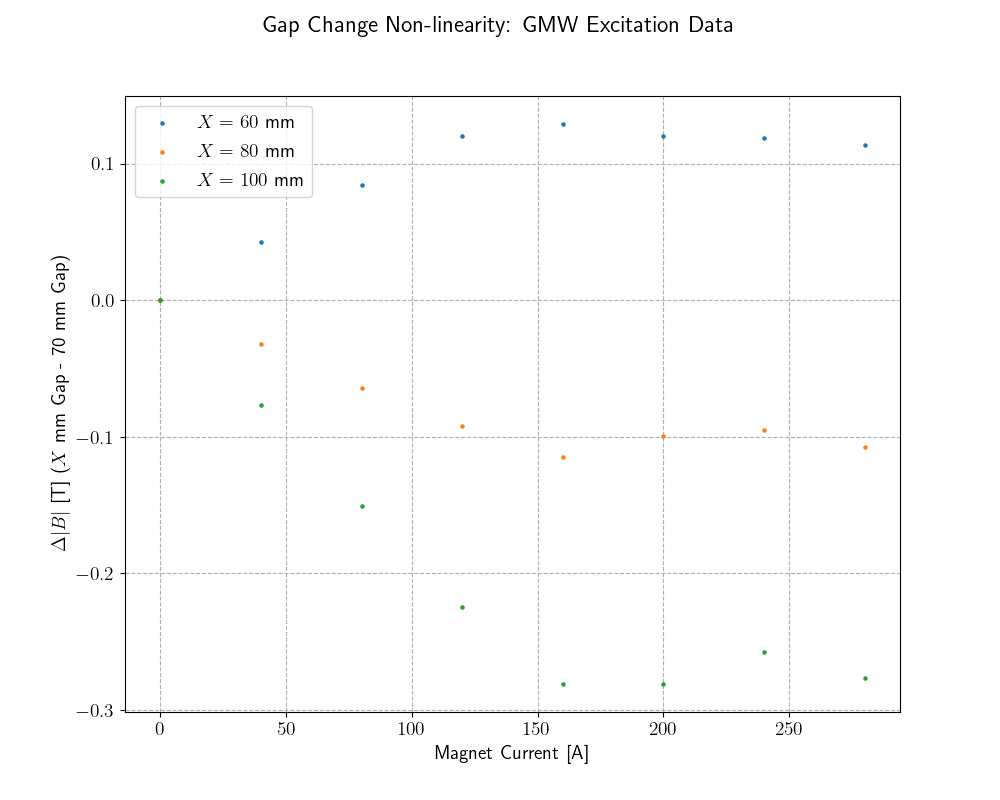

In [236]:
df_ = df_GMW.query('I <= 280.').copy()

fig, ax = plt.subplots()

for f in ['60', '80', '100']:
    ax.scatter(df_.I, df_[f'B_{f}-B_70'], s=5, label=rf'$X = {f}$ mm')

ax.set_xlabel('Magnet Current [A]')
ax.set_ylabel(r'$\Delta |B|$ [T] ($X$ mm Gap - 70 mm Gap)')
fig.suptitle('Gap Change Non-linearity: GMW Excitation Data')
ax.legend();

<IPython.core.display.Javascript object>


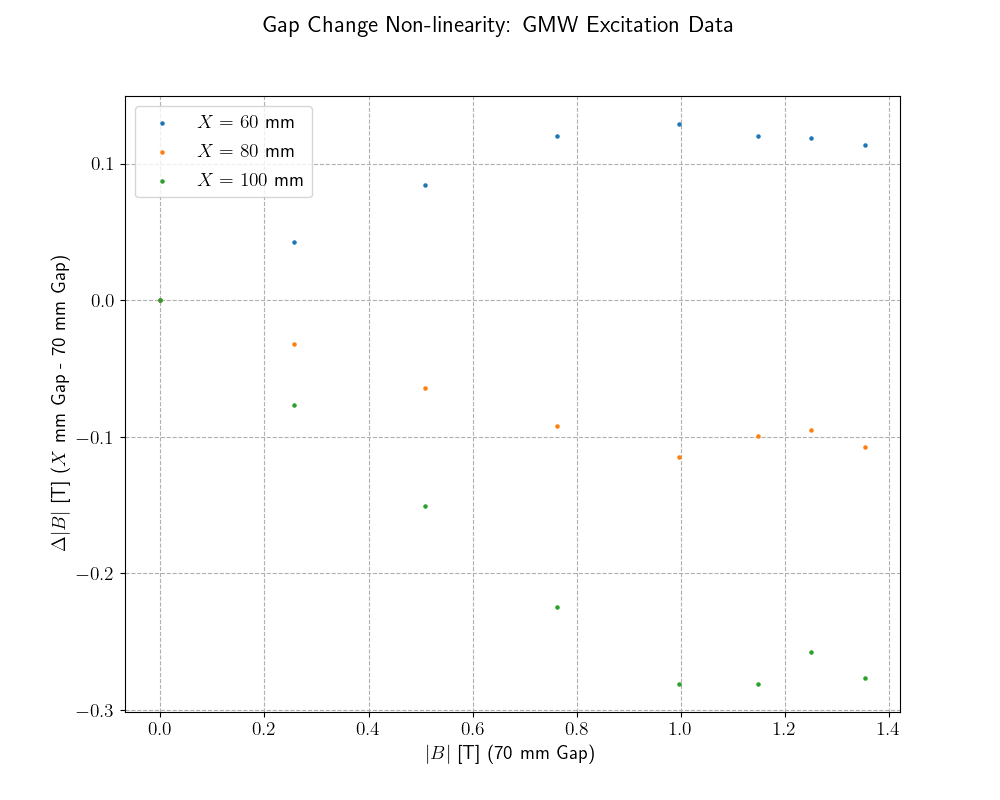

In [240]:
fig, ax = plt.subplots()

for f in ['60', '80', '100']:
    ax.scatter(df_.B_70, df_[f'B_{f}-B_70'], s=5, label=rf'$X = {f}$ mm')

ax.set_xlabel(r'$|B|$ [T] (70 mm Gap)')
ax.set_ylabel(r'$\Delta |B|$ [T] ($X$ mm Gap - 70 mm Gap)')
fig.suptitle('Gap Change Non-linearity: GMW Excitation Data')
ax.legend();

# |B| Angle

In [265]:
df_ramp.query('run_num == 4').iloc[0][[f'{probe}_Cal_X', f'{probe}_Cal_Y', f'{probe}_Cal_Z']].values

array([0.184131485, -0.0054833, 0.006865619], dtype=object)

In [266]:
# CAL
B0 = df_ramp.query('run_num == 4').iloc[0][[f'{probe}_Cal_X', f'{probe}_Cal_Y', f'{probe}_Cal_Z']].values
B0_mag = np.linalg.norm(B0)
Bs = df_ramp[[f'{probe}_Cal_X', f'{probe}_Cal_Y', f'{probe}_Cal_Z']].values
Bmags = df_ramp[f'{probe}_Cal_Bmag'].values

B_angles = np.arccos((np.dot(Bs, B0) / (Bmags*B0_mag)).astype(np.float64))

df_ramp[f'{probe}_Cal_Angle'] = B_angles

In [267]:
# RAW
B0 = df_ramp.query('run_num == 4').iloc[0][[f'{probe}_Raw_X', f'{probe}_Raw_Y', f'{probe}_Raw_Z']].values
B0_mag = np.linalg.norm(B0)
Bs = df_ramp[[f'{probe}_Raw_X', f'{probe}_Raw_Y', f'{probe}_Raw_Z']].values
Bmags = df_ramp[f'{probe}_Raw_Bmag'].values

B_angles = np.arccos((np.dot(Bs, B0) / (Bmags*B0_mag)).astype(np.float64))

df_ramp[f'{probe}_Raw_Angle'] = B_angles

In [268]:
df_ = df_ramp.query('`Magnet Current [A]`>10').copy()

<IPython.core.display.Javascript object>


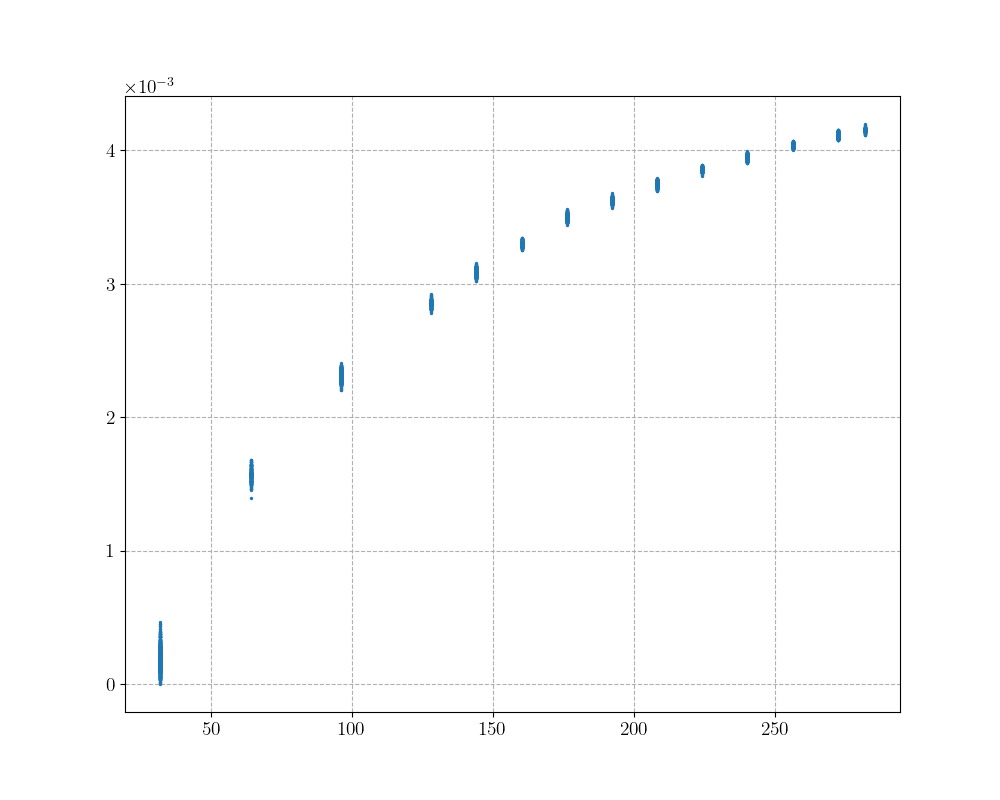

In [269]:
fig, ax = plt.subplots()
ax.scatter(df_['Magnet Current [A]'], df_[f'{probe}_Raw_Angle'], s=2)
# ax.set_xlim([20, 290])
# ax.set_ylim([-1e-3, 1e-3])
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

<IPython.core.display.Javascript object>


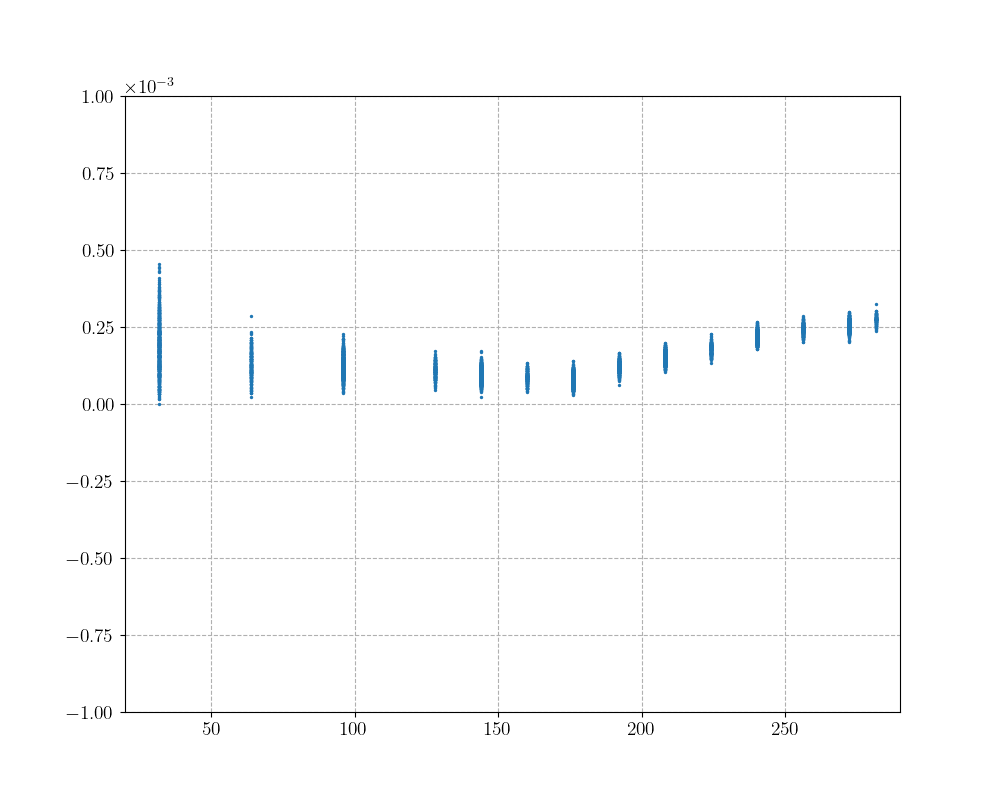

In [270]:
fig, ax = plt.subplots()
ax.scatter(df_ramp['Magnet Current [A]'], df_ramp[f'{probe}_Cal_Angle'], s=2)
ax.set_xlim([20, 290])
ax.set_ylim([-1e-3, 1e-3])
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

In [193]:
probe

'6A0000000D61333A'

In [195]:
for c in df_ramp.columns:
    if probe in c:
        print(c)

6A0000000D61333A_Raw_X
6A0000000D61333A_Raw_Y
6A0000000D61333A_Raw_Z
6A0000000D61333A_Raw_T
6A0000000D61333A_Cal_X
6A0000000D61333A_Cal_Y
6A0000000D61333A_Cal_Z
6A0000000D61333A_Cal_T
6A0000000D61333A_Cal_Bmag
6A0000000D61333A_Raw_Bmag
6A0000000D61333A_Cal_Theta
6A0000000D61333A_Cal_Phi


In [181]:
np.dot(Bs[0], B0), np.dot(Bs[1], B0)

(-0.000158025011435685, -0.000167340730865648)

In [177]:
Bs.shape

(6711, 3)

In [221]:
fig, ax = plt.subplots()
ax.scatter(df_info_nmr.I, df_info_nmr.B_reg, s=2, c='blue')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


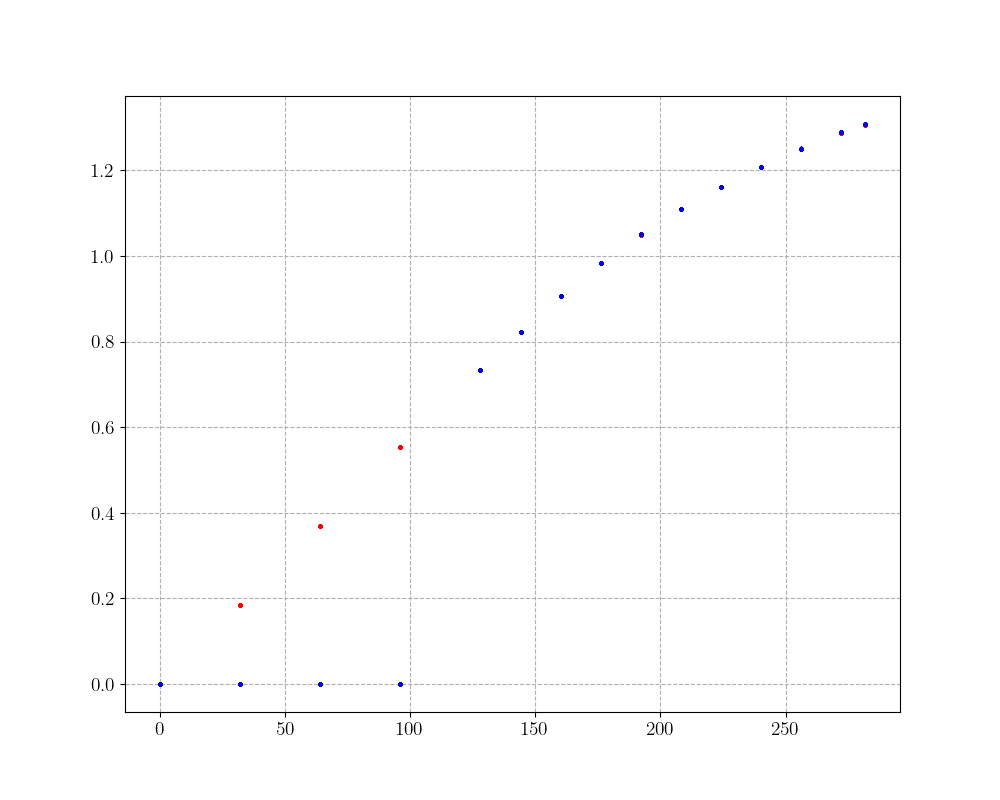

In [271]:
fig, ax = plt.subplots()
ax.scatter(df_ramp['Magnet Current [A]'], df_ramp[f'{probe}_Cal_Bmag'], c='red', s=2)
# ax2 = ax1.twinx()
ax.scatter(df_ramp['Magnet Current [A]'], df_ramp['NMR [T]'], c='blue', s=2)
# ax.set_xlim([20, 290])

<IPython.core.display.Javascript object>


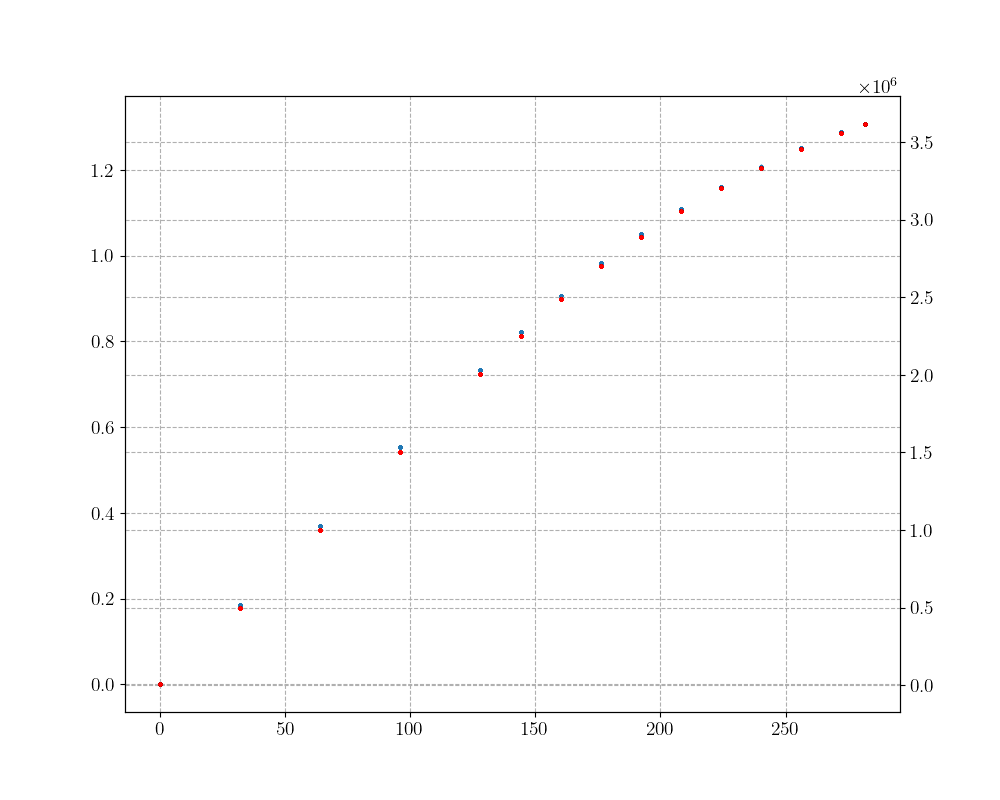

In [272]:
fig, ax1 = plt.subplots()
ax1.scatter(df_ramp['Magnet Current [A]'], df_ramp[f'{probe}_Cal_Bmag'], s=2)
ax2 = ax1.twinx()
ax2.scatter(df_ramp['Magnet Current [A]'], df_ramp[f'{probe}_Raw_Bmag'], c='red', s=2)
# ax.set_xlim([20, 290])
# ax.set_ylim([-1e-3, 1e-3])
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

<IPython.core.display.Javascript object>


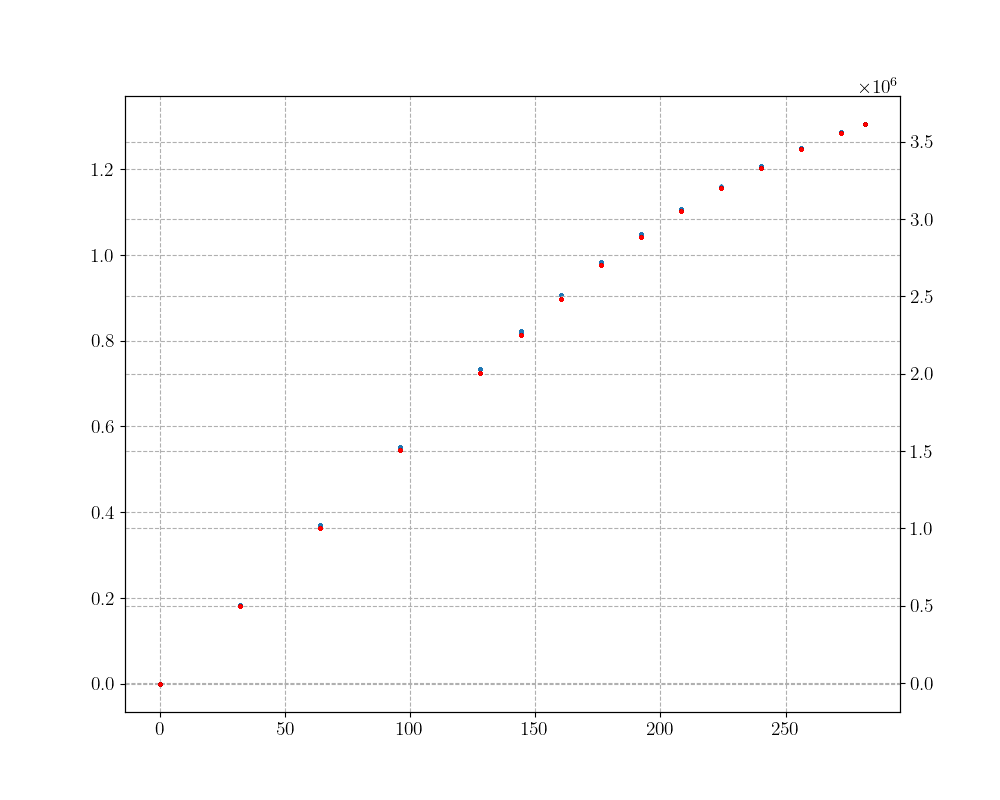

In [273]:
# X
fig, ax1 = plt.subplots()
ax1.scatter(df_ramp['Magnet Current [A]'], df_ramp[f'{probe}_Cal_X'], s=2)
ax2 = ax1.twinx()
ax2.scatter(df_ramp['Magnet Current [A]'], -df_ramp[f'{probe}_Raw_Z'], c='red', s=2)

<IPython.core.display.Javascript object>


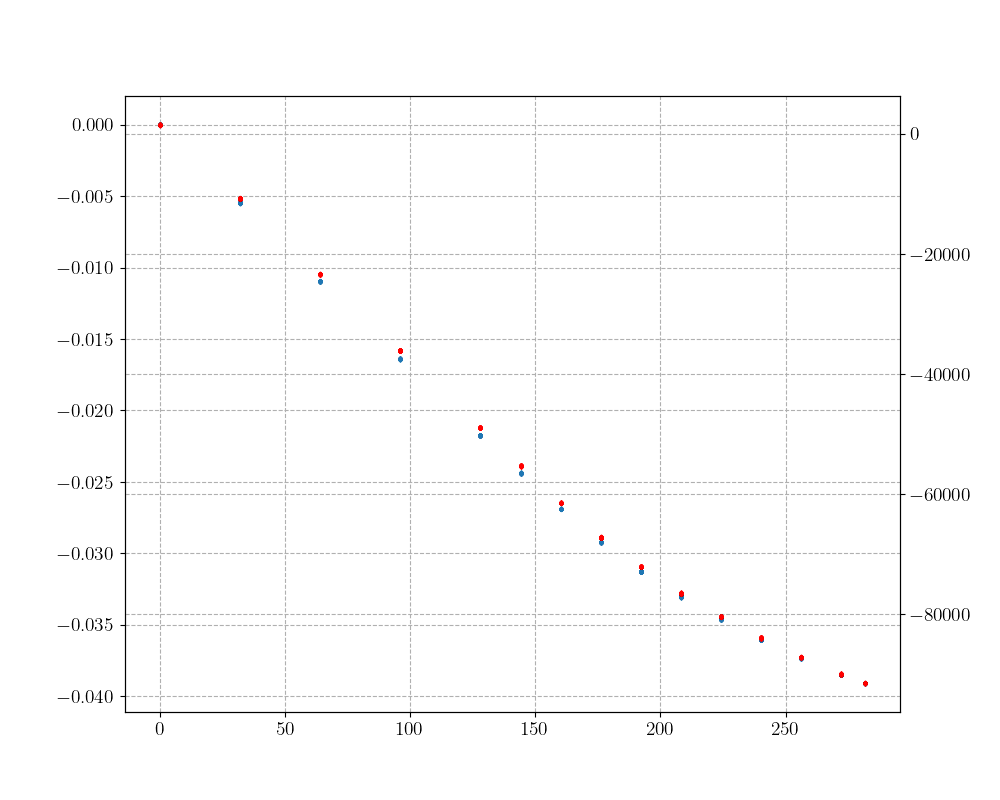

In [274]:
# Y
fig, ax1 = plt.subplots()
ax1.scatter(df_ramp['Magnet Current [A]'], df_ramp[f'{probe}_Cal_Y'], s=2)
ax2 = ax1.twinx()
ax2.scatter(df_ramp['Magnet Current [A]'], df_ramp[f'{probe}_Raw_Y'], c='red', s=2)

<IPython.core.display.Javascript object>


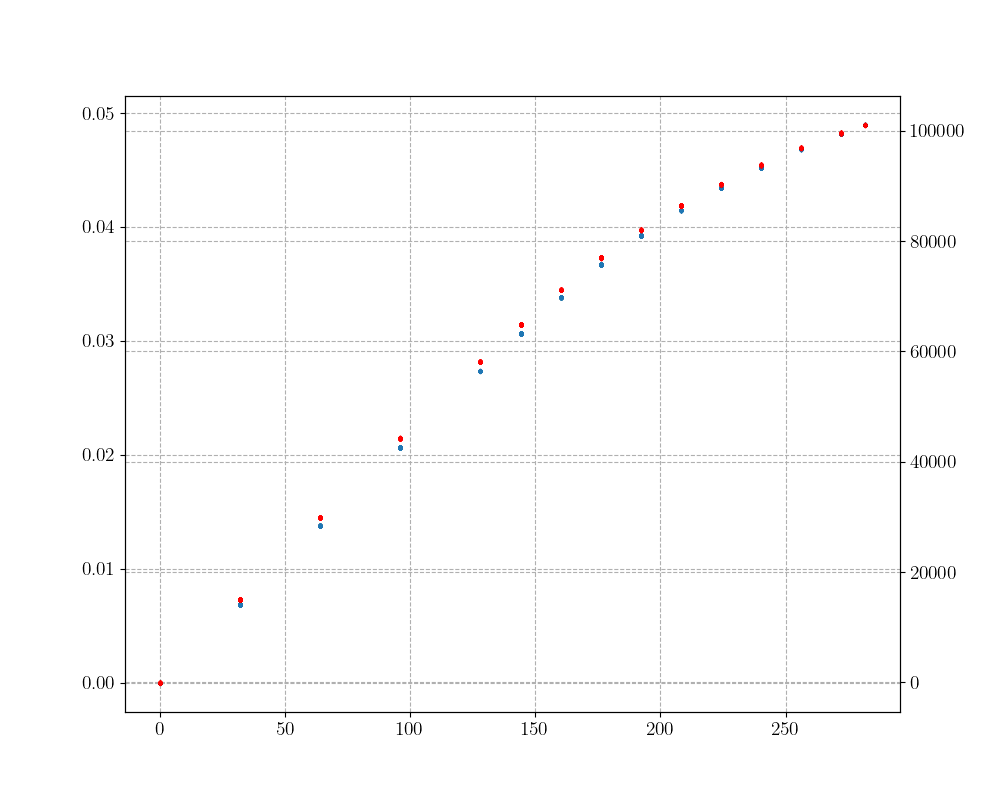

In [275]:
# Z
fig, ax1 = plt.subplots()
ax1.scatter(df_ramp['Magnet Current [A]'], df_ramp[f'{probe}_Cal_Z'], s=2)
ax2 = ax1.twinx()
ax2.scatter(df_ramp['Magnet Current [A]'], -df_ramp[f'{probe}_Raw_X'], c='red', s=2)

# Current vs. I

In [307]:
# power
df_ramp['Power'] = df_ramp['Magnet Current [A]'] * df_ramp['Magnet Voltage [V]'] / 1000

<IPython.core.display.Javascript object>


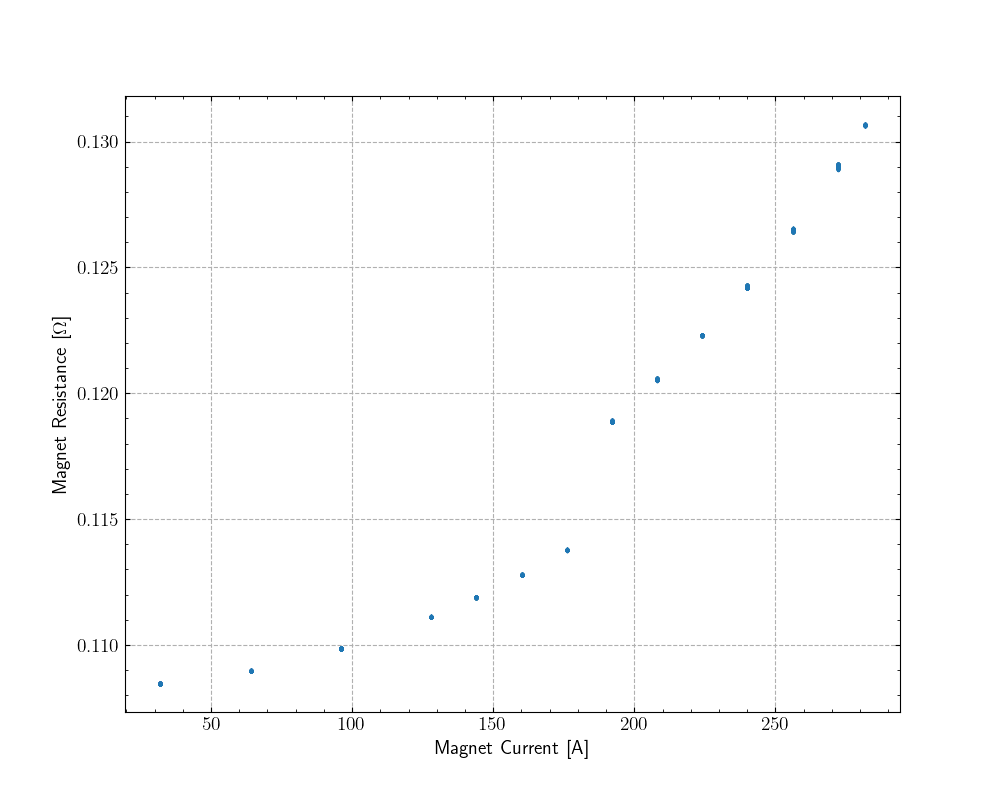

In [301]:
# df_ = df_ramp.query('`NMR [T]` > 0.1').copy()
# df_ = df_ramp.copy()
df_ = df_ramp.query('`Magnet Current [A]` > 1').copy()
fig, ax = plt.subplots()

# ax.scatter(df_['Magnet Current [A]'], df_['Magnet Voltage [V]'], s=2)
# ax.set_xlabel(r'Magnet Current [A]')

ax.scatter(df_['Magnet Current [A]'], df_['Magnet Voltage [V]']/df_['Magnet Current [A]'], s=2)
ax.set_xlabel(r'Magnet Current [A]')

# ax.set_ylabel('Magnet Voltage [V]')
ax.set_ylabel(r'Magnet Resistance [$\Omega$]')

# ticks in
ax.tick_params(which='both', direction='in', top=True, right=True)
# autolocate minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

In [303]:
# quadratic fit
# power in kW

In [308]:
def q(x, **params):
    return params['a']+params['b']*x+params['c']*x**2

In [315]:
#df_ = df_ramp.query('`NMR [T]` > 0.1').copy()
df_ = df_ramp.copy()
model = lm.Model(q, independent_vars=['x'])
params = lm.Parameters()
params.add('a', value=0, vary=False)
params.add('b', value=0, vary=True)
params.add('c', value=0, vary=True)
# result = model.fit(df_.Power.values, x=df_['NMR [T]'].values, params=params)
result = model.fit(df_.Power.values, x=df_['Magnet Current [A]'].values, params=params)

In [316]:
result

In [324]:
result.eval(x=300)

11.627108064493251

<IPython.core.display.Javascript object>


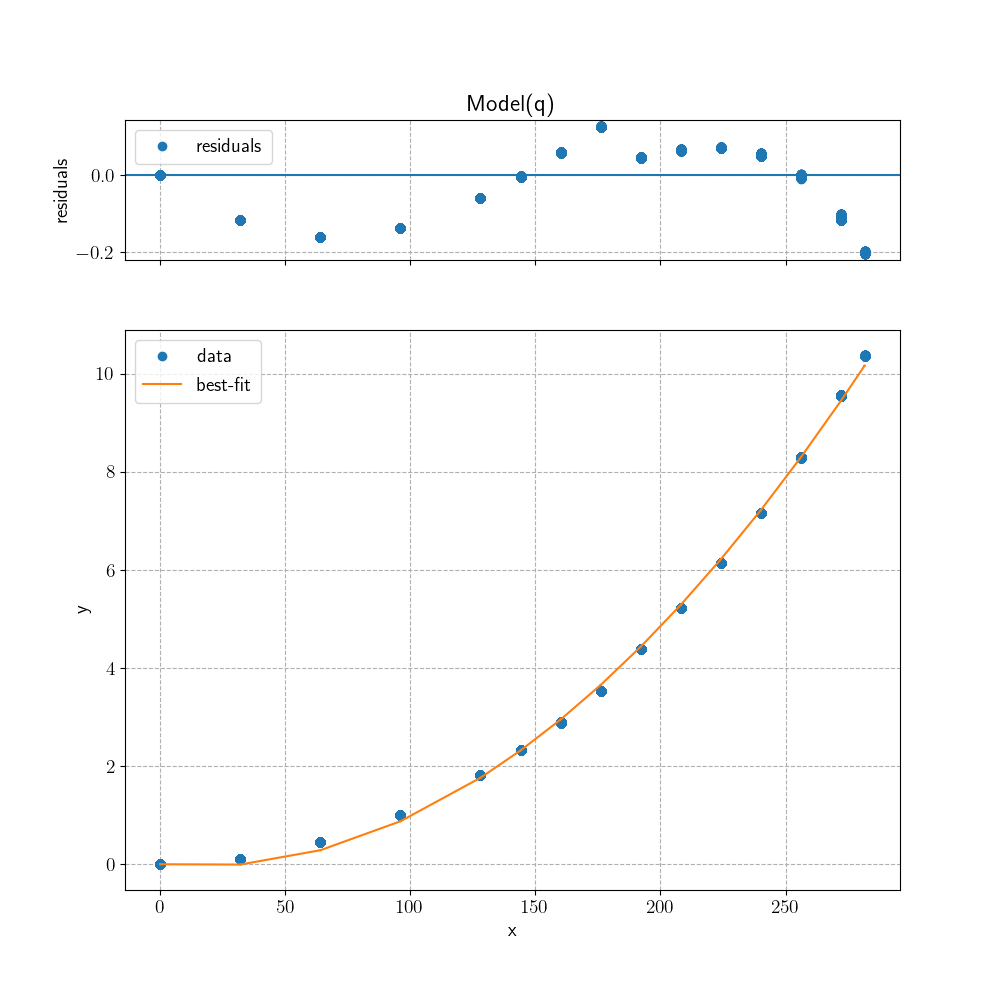

(<Figure size 1000x1000 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

In [317]:
result.plot()

In [333]:
df_.index[0]

Timestamp('2021-03-01 13:21:43')

In [335]:
df_info_nmr.iloc[0]

t0               2021-03-03 09:16:30
tf               2021-03-03 17:11:45
ramp                            True
hyst                           False
adc                          400,000
chiller                         True
NMR                             True
B_NMR                       0.732467
I                         128.038948
hours_data                  7.920833
num_meas                         476
B_reg                        0.73399
sigma_B_reg                 0.000004
B_ratio                     0.999966
sigma_B_ratio               0.000008
Name: 7, dtype: object

In [325]:
probe

'6A0000000D61333A'

<IPython.core.display.Javascript object>


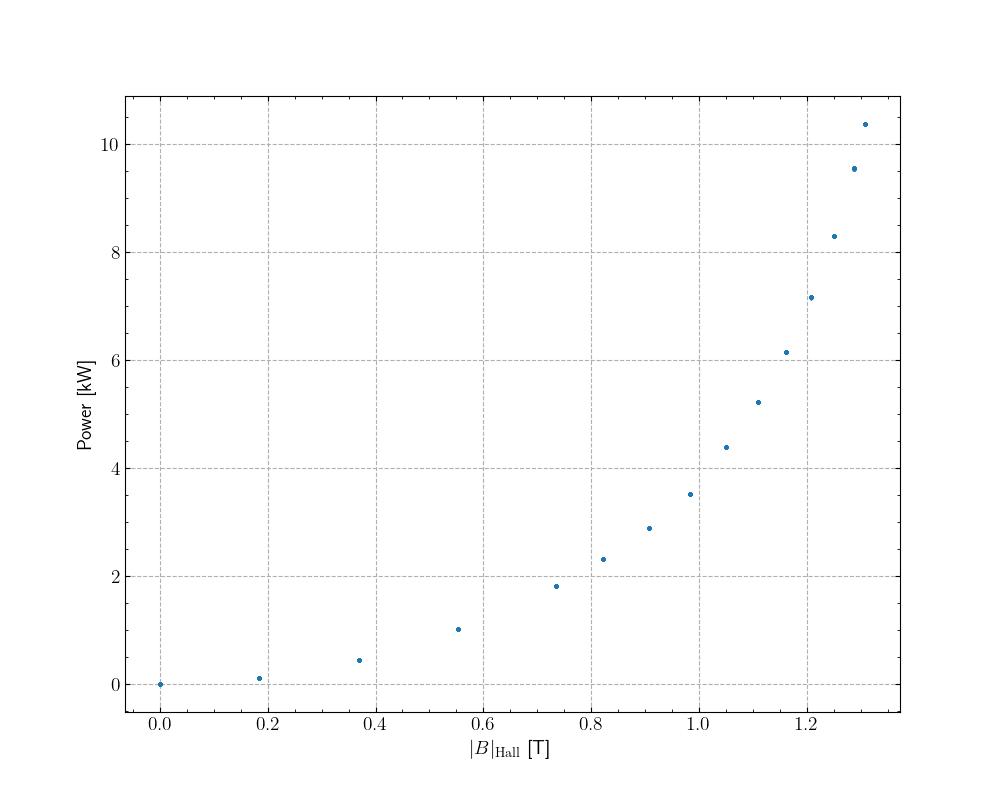

In [326]:
#df_ = df_ramp.query('`NMR [T]` > 0.1').copy()
df_ = df_ramp.copy()
fig, ax = plt.subplots()

# ax.scatter(df_['NMR [T]'], df_['Power'], s=2)
# ax.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')

ax.scatter(df_[f'{probe}_Cal_Bmag'], df_['Power'], s=2)
ax.set_xlabel(r'$|B|_{\mathrm{Hall}}$ [T]')

# ax.scatter(df_['Magnet Current [A]'], df_['Power'], s=2)
# ax.set_xlabel(r'Magnet Current [A]')

ax.set_ylabel('Power [kW]')
# ticks in
ax.tick_params(which='both', direction='in', top=True, right=True)
# autolocate minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df_ramp['Magnet Current [A]', df_ramp['Magnet Current [A]'], s=1)

<IPython.core.display.Javascript object>


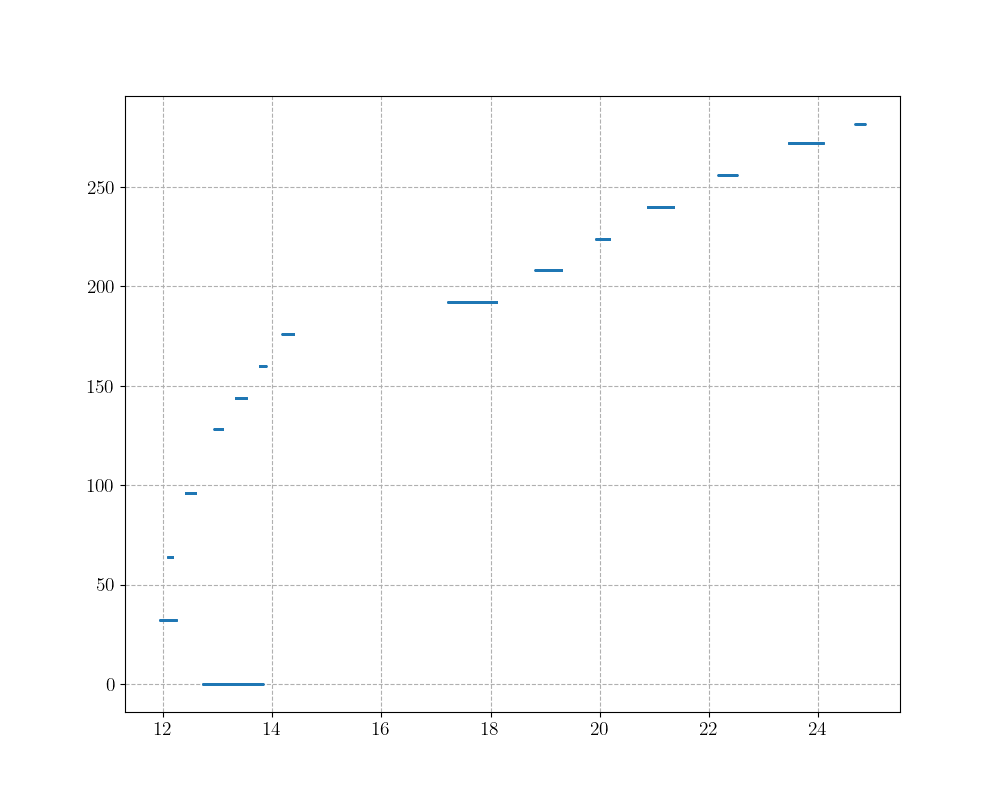

In [241]:
fig, ax = plt.subplots()
ax.scatter(df_ramp['Yoke (center magnet)'], df_ramp['Magnet Current [A]'], s=1)

In [250]:
Is = df_info.I.values
As = []
Bs = []
for i in range(len(results_nmr)):
    p_ = results_nmr[i].params
    As.append(p_['A'])
    Bs.append(p_['B'])
As = np.array(As)
Bs = np.array(Bs)
m = df_info.ramp
Is = Is[m]
As = As[m]
Bs = Bs[m]

<IPython.core.display.Javascript object>


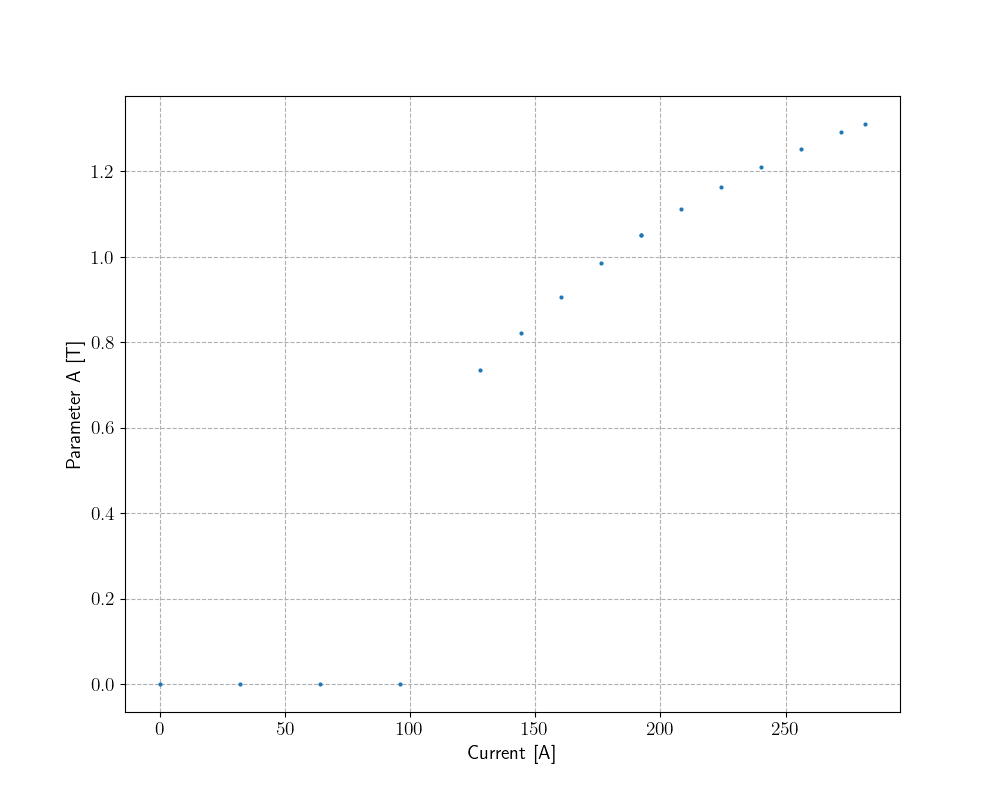

Text(0, 0.5, 'Parameter A [T]')

In [251]:
# A
fig, ax = plt.subplots()
ax.scatter(Is, As, s=4)
ax.set_xlabel('Current [A]')
ax.set_ylabel('Parameter A [T]')

<IPython.core.display.Javascript object>


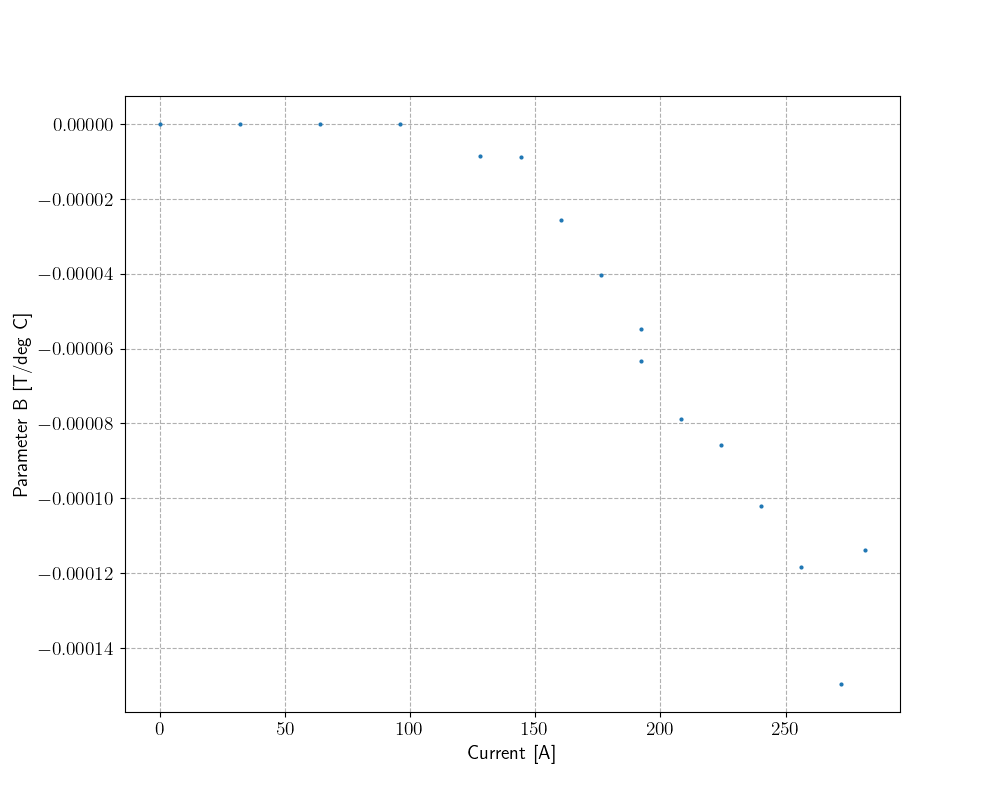

Text(0, 0.5, 'Parameter B [T/deg C]')

In [252]:
fig, ax = plt.subplots()
ax.scatter(Is, Bs, s=4)
ax.set_xlabel('Current [A]')
ax.set_ylabel('Parameter B [T/deg C]')

# Fractional Correction

In [285]:
def const_B(I, T, interpfunc=interpNMR, **params):
    return interpfunc(I) + params['a']*(T-params['T0'])

def lin_B(I, T, interpfunc=interpNMR, **params):
    return interpfunc(I) * (1 + params['a']*(T-params['T0']))

def lin_I(I, T, interpfunc=interpNMR, **params):
    return interpfunc(I) + (params['b']+I*params['a'])*(T-params['T0'])

def quad_I(I, T, interpfunc=interpNMR, **params):
    return interpfunc(I) + (params['b']+I**2*params['a'])*(T-params['T0'])

def linquad_I(I, T, interpfunc=interpNMR, **params):
    return interpfunc(I) + (params['c'] + I*params['b']+I**2*params['a'])*(T-params['T0'])


# def lin_I(I, **params, interpfunc=interpNMR):
#     return interpNMR(I) + (params['dBdT'])

In [286]:
# NMR
ycol = 'NMR [T]'
df_ = df_ramp[df_ramp.run_num >= 7].copy()

# Hall
# ycol = f'{probe}_Cal_Bmag'
# df_ = df_ramp.copy()


Imax = 250. #270. # 250. #180.
# Imax = 300.
# Imin = -10.
Imin = 120. # NMR
df_ = df_.query(f'{Imin} < `Magnet Current [A]` < {Imax}').copy()

# NMR
std_ = 5e-6 * np.ones(len(df_))
# Hall
# std_ = 3e-5 * np.ones(len(df_))

# model = lm.Model(const_B, independent_vars=['I', 'T', 'interpfunc'])
# model = lm.Model(lin_B, independent_vars=['I', 'T', 'interpfunc'])
# model = lm.Model(lin_I, independent_vars=['I', 'T', 'interpfunc'])
# model = lm.Model(quad_I, independent_vars=['I', 'T', 'interpfunc'])
model = lm.Model(linquad_I, independent_vars=['I', 'T', 'interpfunc'])
params = lm.Parameters()
params.add('a', value=0, vary=True)
# params.add('a', value=0, vary=False)
params.add('b', value=0, vary=True)
params.add('c', value=0, vary=True)
params.add('T0', value=15, vary=False)
# NMR
result = model.fit(df_[ycol].values, I=df_['Magnet Current [A]'].values, T=df_['Yoke (center magnet)'].values, interpfunc=interpNMR, params=params, weights=1/std_, scale_covar=False,
                   method='leastsq')#default
                   #method='least_squares', fit_kws={'loss':'huber'})
# Hall
# result = model.fit(df_[ycol].values, I=df_['Magnet Current [A]'].values, T=df_['Yoke (center magnet)'].values, interpfunc=interpHall, params=params, weights=1/std_, scale_covar=False,
#                    method='leastsq')#default
#                    #method='least_squares', fit_kws={'loss':'huber'})

In [287]:
result

[ 2.21109433e-05  2.17802085e-05  2.24666317e-05 ...  9.79402505e-07
 -5.88933974e-07 -9.64285634e-07]


<IPython.core.display.Javascript object>


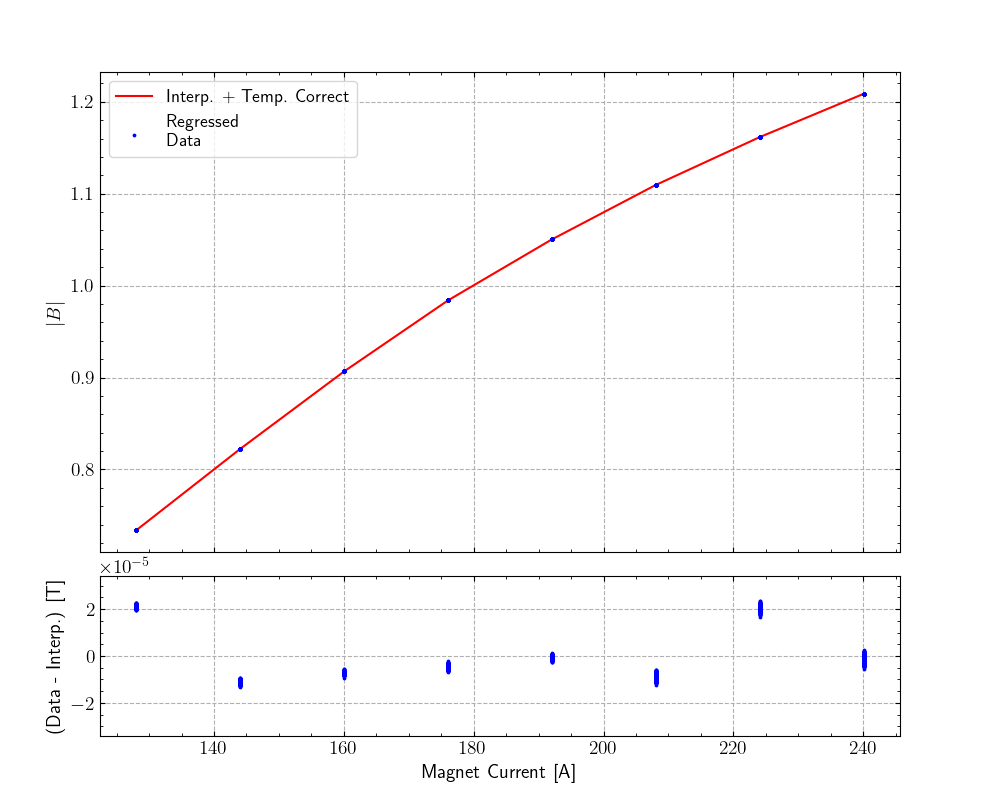

In [288]:
# calculate residuals
res = df_[ycol].values - result.best_fit
print(res)
yl = 1.2*(np.max(np.abs(res)) + np.max(std_nmr))
# plot
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.31, 0.8, 0.6))
ax2 = fig.add_axes((0.1, 0.08, 0.8, 0.2))
label_data = f'Regressed\nData' #({ycol})'
# ax1.errorbar(df_['Magnet Current [A]'].values, df_[ycol].values, yerr=std_, c='blue',
#              fmt='.', ls='none', ms=6, zorder=100, capsize=3,
#              label=label_data)
ax1.scatter(df_['Magnet Current [A]'].values, df_[ycol].values, c='blue', s=3,
            zorder=100, label=label_data)
ax1.plot(df_['Magnet Current [A]'].values, result.best_fit, c='red', zorder=99, label='Interp. + Temp. Correct')
# ax2.errorbar(df_['Magnet Current [A]'].values, res, yerr=std_, c='blue',
#              fmt='.', ls='none', ms=6, zorder=100, capsize=3,
#              label=label_data)
ax2.scatter(df_['Magnet Current [A]'].values, res, c='blue', s=3,
            zorder=100, label=label_data)
# set ylimits
ax2.set_ylim([-yl, yl])
# remove ticklabels for ax1 xaxis
ax1.set_xticklabels([])
# minor ticks
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax1.tick_params(which='both', direction='in', top=True, right=True,
                bottom=True)
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# axis labels
ax2.set_xlabel('Magnet Current [A]')
ax2.set_ylabel(f'(Data - Interp.) [T]')
ax1.set_ylabel(r'$|B|$')
ax1.legend(fontsize=13).set_zorder(101);

<IPython.core.display.Javascript object>


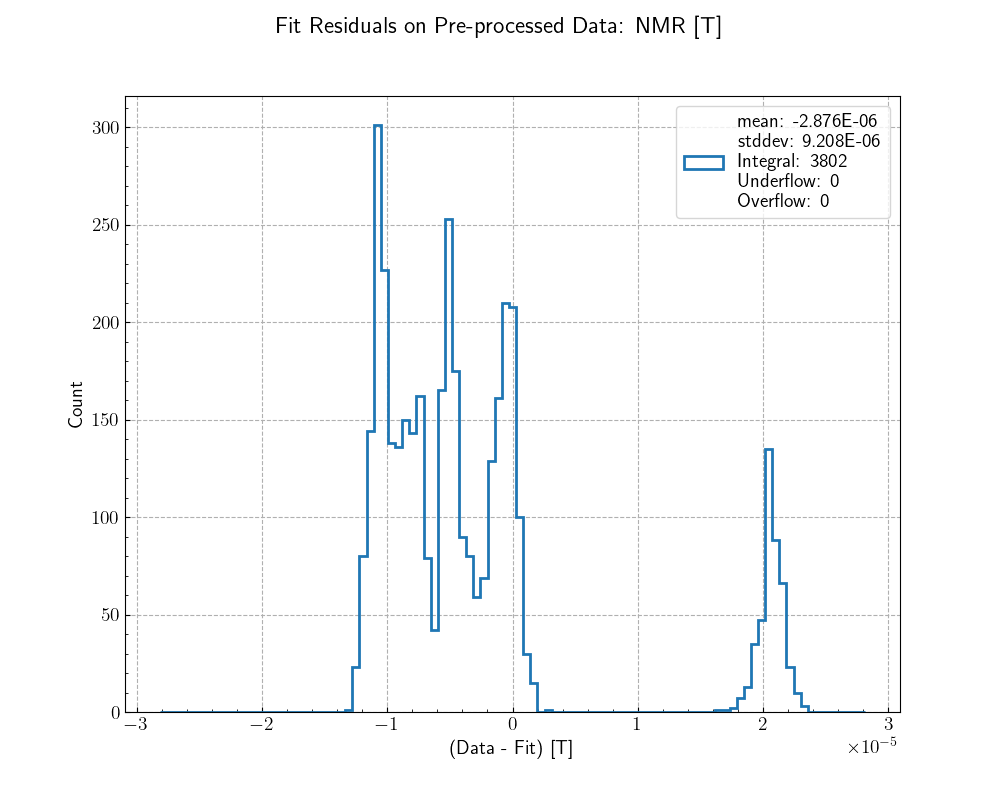

In [264]:
# HISTOGRAM
fig, ax = plt.subplots()
rmax = 1.2 * np.max(np.abs(res))
nbins=100#200#100
bins = np.linspace(-rmax, rmax, nbins)
ax.hist(res, bins=bins, histtype='step', linewidth=2,
        label=get_label(res, bins))
# formatting
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks
ax.tick_params(which='both', direction='in',)# top=True, right=True)
# labels
# ax_2.set_xlabel(f'(Data ({ycol}) - {ylab}) [T]')
ax.set_xlabel(f'(Data - Fit) [T]')
ax.set_ylabel('Count')
fig.suptitle(f'Fit Residuals on Pre-processed Data: {ycol}')
ax.legend();
# ax.set_yscale('log');

<IPython.core.display.Javascript object>


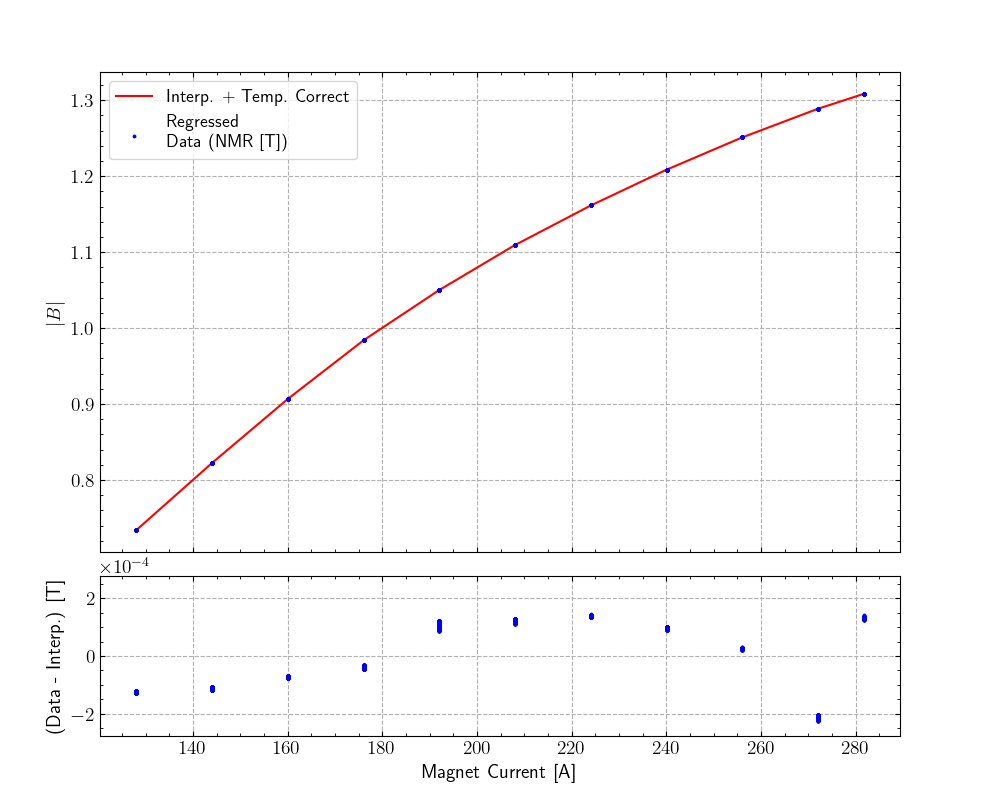

In [42]:
# calculate residuals
res = df_[ycol].values - result.best_fit
yl = 1.2*(np.max(np.abs(res)) + np.max(std_nmr))
# plot
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.31, 0.8, 0.6))
ax2 = fig.add_axes((0.1, 0.08, 0.8, 0.2))
label_data = f'Regressed\nData ({ycol})'
# ax1.errorbar(df_['Magnet Current [A]'].values, df_[ycol].values, yerr=std_, c='blue',
#              fmt='.', ls='none', ms=6, zorder=100, capsize=3,
#              label=label_data)
ax1.scatter(df_['Magnet Current [A]'].values, df_[ycol].values, c='blue', s=3,
            zorder=100, label=label_data)
ax1.plot(df_['Magnet Current [A]'].values, result.best_fit, c='red', zorder=99, label='Interp. + Temp. Correct')
# ax2.errorbar(df_['Magnet Current [A]'].values, res, yerr=std_, c='blue',
#              fmt='.', ls='none', ms=6, zorder=100, capsize=3,
#              label=label_data)
ax2.scatter(df_['Magnet Current [A]'].values, res, c='blue', s=3,
            zorder=100, label=label_data)
# set ylimits
ax2.set_ylim([-yl, yl])
# remove ticklabels for ax1 xaxis
ax1.set_xticklabels([])
# minor ticks
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax1.tick_params(which='both', direction='in', top=True, right=True,
                bottom=True)
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# axis labels
ax2.set_xlabel('Magnet Current [A]')
ax2.set_ylabel(f'(Data - Interp.) [T]')
ax1.set_ylabel(r'$|B|$')
ax1.legend(fontsize=13).set_zorder(101)

In [ ]:
a = -1.5e-4#-1e-4
            # Bs_fit = result_B_vs_I(Is) + (a * (Is-120)/(280-120)) * (Ts-T0)
            Bs_fit = result_B_vs_I(Is) + (a * (Is/280)**2) * (Ts-T0)

In [7]:
interpNMR(280), interpHall(280)

(array(1.30620494), array(1.30490771))

In [16]:
Is = np.linspace(125, 280, 200)
B_Hall = interpHall(Is)
B_NMR = interpNMR(Is)
B_rat = B_Hall/B_NMR

<IPython.core.display.Javascript object>


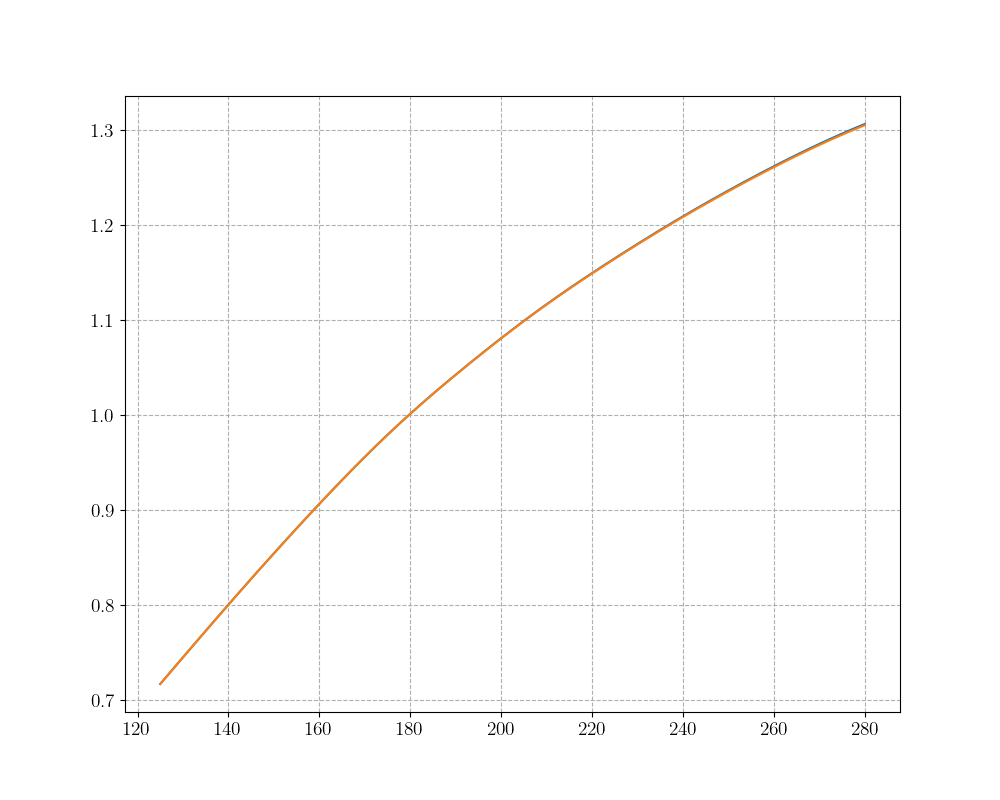

In [17]:
fig, ax = plt.subplots()
ax.plot(Is, B_NMR)
ax.plot(Is, B_Hall)

<IPython.core.display.Javascript object>


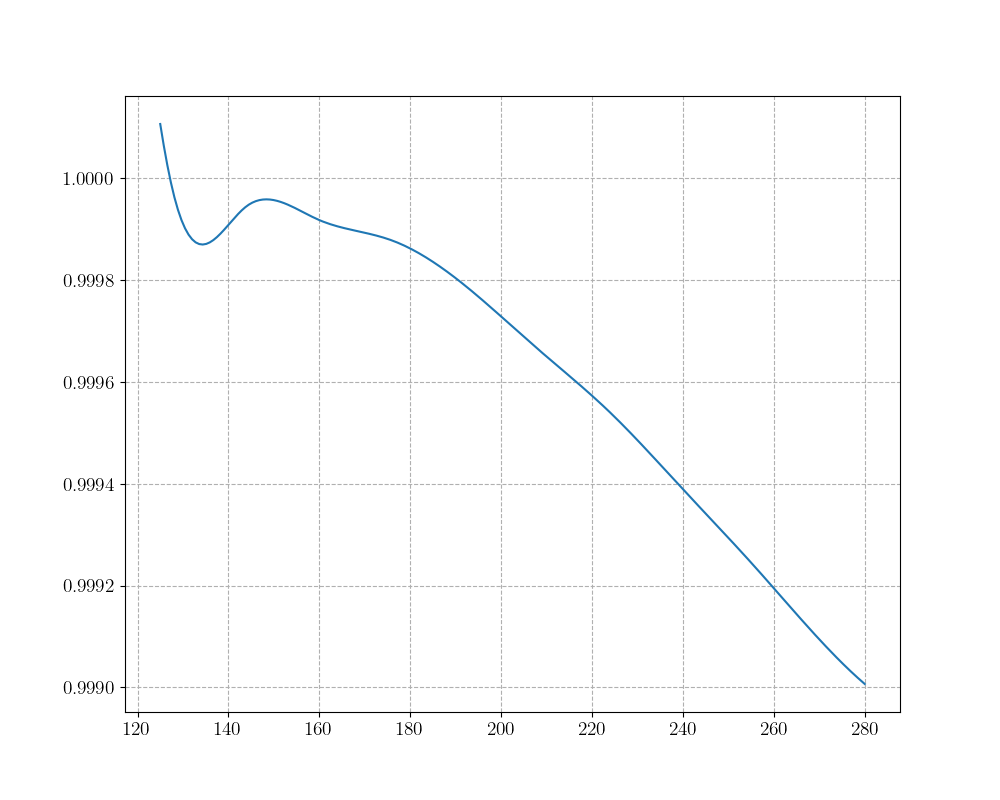

In [18]:
fig, ax = plt.subplots()
ax.plot(Is, B_rat)

# OLD

In [86]:
# load info df
df_info = pd.read_pickle(pklinfo)
proc_ramp = pd.read_pickle(pklproc_ramp)
proc_hyst = pd.read_pickle(pklproc_hyst)
results_nmr = pkl.load(open(pklfit_temp_nmr, 'rb'))
results_hall = pkl.load(open(pklfit_temp_hall, 'rb'))
results_hall_nmr = pkl.load(open(pklfit_temp_hall_nmr, 'rb'))

In [87]:
results_nmr[0]

In [73]:
proc_ramp

Time  Magnet Current [A]  \
Datetime                                                        
2021-03-01 13:21:43   3/1/2021 1:21:43 PM            0.000849   
2021-03-01 13:22:43   3/1/2021 1:22:43 PM            0.001091   
2021-03-01 13:23:43   3/1/2021 1:23:43 PM            0.001039   
2021-03-01 13:24:43   3/1/2021 1:24:43 PM            0.000718   
2021-03-01 13:25:43   3/1/2021 1:25:43 PM            0.001004   
...                                   ...                 ...   
2021-03-11 17:46:47  3/11/2021 5:46:47 PM          281.677420   
2021-03-11 17:47:47  3/11/2021 5:47:47 PM          281.677477   
2021-03-11 17:48:47  3/11/2021 5:48:47 PM          281.677647   
2021-03-11 17:49:47  3/11/2021 5:49:47 PM          281.677420   
2021-03-11 17:50:47  3/11/2021 5:50:47 PM          281.677533   

                     Magnet Voltage [V]  Coil 1 (new)  Coil 2 (old)  \
Datetime                                                              
2021-03-01 13:21:43            0.000395      7.688446      7.691459   
2021-03-01 13:22:43           -0.001118      7.643955      7.702847   
2021-03-01 13:23:43           -0.000333      7.624253      7.710751   
2021-03-01 13:24:43            0.000996      7.651546      7.712375   
2021-03-01 13:25:43           -0.000206      7.638594      7.720768   
...                                 ...           ...           ...   
2021-03-11 17:46:47           36.814150     51.974365     51.455513   
2021-03-11 17:47:47           36.814183     51.953983     51.460171   
2021-03-11 17:48:47           36.814433     51.900555     51.444550   
2021-03-11 17:49:47           36.814683     51.927181     51.474323   
2021-03-11 17:50:47           36.815050     51.835213     51.468891   

                     LCW in Coil1  LCW out Coil 1  LCW in Coil 2  \
Datetime                                                           
2021-03-01 13:21:43      6.898076        7.368879       7.800656   
2021-03-01 13:22:43      6.885967        7.356124       7.805821   
2021-03-01 13:23:43      6.905254        7.374886       7.772696   
2021-03-01 13:24:43      6.935202        7.386232       7.751643   
2021-03-01 13:25:43      6.922057        7.367510       7.786451   
...                           ...             ...            ...   
2021-03-11 17:46:47     16.494814       22.697769      23.309382   
2021-03-11 17:47:47     16.498129       22.703094      23.390150   
2021-03-11 17:48:47     16.515627       22.720036      23.383900   
2021-03-11 17:49:47     16.512764       22.711113      23.357107   
2021-03-11 17:50:47     16.527004       22.714041      23.386671   

                     LCW out Coil 2       Yoke  ...  \
Datetime                                        ...   
2021-03-01 13:21:43        6.925324  12.731566  ...   
2021-03-01 13:22:43        6.908267  12.722416  ...   
2021-03-01 13:23:43        6.924972  12.710895  ...   
2021-03-01 13:24:43        6.941383  12.705977  ...   
2021-03-01 13:25:43        6.953355  12.700392  ...   
...                             ...        ...  ...   
2021-03-11 17:46:47       31.614250  25.736761  ...   
2021-03-11 17:47:47       31.622131  25.739260  ...   
2021-03-11 17:48:47       31.625975  25.749882  ...   
2021-03-11 17:49:47       31.645779  25.743784  ...   
2021-03-11 17:50:47       31.620852  25.749489  ...   

                     C90000000D53983A_Cal_Theta  C90000000D53983A_Cal_Phi  \
Datetime                                                                    
2021-03-01 13:21:43                    1.161876                 -2.253625   
2021-03-01 13:22:43                    1.141849                 -2.348143   
2021-03-01 13:23:43                    1.235545                 -1.874310   
2021-03-01 13:24:43                    0.928488                 -2.412174   
2021-03-01 13:25:43                    1.465051                 -2.176981   
...                                         ...                       ...   
2021-03-11 17:46:47                    0.934414   

In [88]:
ramps = df_info[df_info.ramp].index
df_ramp = df[np.isin(df.run_num, ramps)]

In [89]:
ramps

Int64Index([3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18], dtype='int64')

In [84]:
nmrs = df_info[df_info.NMR].index
proc_ramp_nmr = df[np.isin(df.run_num, ramps)]

In [74]:
len(df_ramp)

6816

In [70]:
df_ramp.run_num.unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [58]:
df_info

t0                   tf   ramp   hyst      adc  chiller  \
0   2021-02-24 09:57:00  2021-02-25 10:35:45  False   True  750,000     True   
1   2021-02-25 10:36:15  2021-02-26 11:47:45  False   True  700,000     True   
2   2021-02-26 11:53:00  2021-03-01 09:12:45  False   True  750,000     True   
3   2021-03-01 09:18:30  2021-03-01 16:47:45   True  False        0     True   
4   2021-03-01 16:51:30  2021-03-02 09:11:45   True  False  100,000     True   
5   2021-03-02 09:16:30  2021-03-02 16:53:45   True  False  200,000     True   
6   2021-03-02 16:57:30  2021-03-03 09:12:45   True  False  300,000     True   
7   2021-03-03 09:16:30  2021-03-03 17:11:45   True  False  400,000     True   
8   2021-03-03 17:15:30  2021-03-04 09:10:45   True  False  450,000     True   
9   2021-03-04 09:14:45  2021-03-04 16:49:45   True   True  500,000     True   
10  2021-03-04 16:53:30  2021-03-05 09:25:45   True  False  550,000     True   
11  2021-03-05 09:29:45  2021-03-05 14:00:00   True   True  600,000     True   
12  2021-03-08 07:50:45  2021-03-08 17:36:00   True   True  600,000    False   
13  2021-03-08 17:40:45  2021-03-09 09:15:00   True  False  650,000    False   
14  2021-03-09 09:17:00  2021-03-09 17:33:00   True   True  700,000    False   
15  2021-03-09 17:37:00  2021-03-10 09:05:00   True   True  750,000    False   
16  2021-03-10 09:07:45  2021-03-10 18:34:00   True   True  800,000    False   
17  2021-03-10 18:37:45  2021-03-11 09:57:00   True   True  850,000    False   
18  2021-03-11 10:00:45  2021-03-11 17:51:00   True  False  880,000    False   
19  2021-03-11 17:56:00  2021-03-12 09:20:00  False   True  850,000    False   
20  2021-03-12 09:23:45  2021-03-12 18:33:00  False   True  800,000    False   
21  2021-03-12 18:36:45  2021-03-15 17:27:00  False   True  700,000    False   
22  2021-03-15 17:33:45  2021-03-16 09:49:00  False   True  600,000    False   
23  2021-03-16 09:52:45  2021-04-05 08:09:15  False   True  500,000    False   

      NMR     B_NMR           I  hours_data  num_meas  
0    True  1.207960  240.069467   24.645833      1479  
1    True  1.158911  224.065923   25.191667      1512  
2    True  1.208438  240.069009   69.329167      4161  
3   False  0.000000    0.000850    7.487500       450  
4   False  0.000000   32.011006   16.337500       981  
5   False  0.000000   64.021711    7.620833       458  
6   False  0.000000   96.028746   16.254167       976  
7    True  0.732467  128.038948    7.920833       476  
8    True  0.821564  144.044132   15.920833       956  
9    True  0.906698  160.047885    7.583333       456  
10   True  0.981974  176.051258   16.537500       993  
11   True  1.039757  192.056063    4.504167       271  
12   True  1.044941  192.056237    9.754167       586  
13   True  1.109522  208.060745   15.570833       935  
14   True  1.151746  224.065366    8.266667       496  
15   True  1.208615  240.068824   15.466667       929  
16   True  1.248891  256.071131    9.437500       567  
17   True  1.285747  272.075589   15.320833       920  
18   True  1.302796  281.677455    7.837500       471  
19   True  1.288388  272.075324   15.400000       924  
20   True  1.248529  256.070678    9.154167       550  
21   True  1.159084  224.064884   70.837500      4191  
22   True  1.049826  192.055609   16.254167       976  
23   True  0.905710  160.047416  478.275000     28697

In [45]:
df = pd.read_pickle(pklproc)

In [47]:
df.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'Coil 1 (new)',
       'Coil 2 (old)', 'LCW in Coil1', 'LCW out Coil 1', 'LCW in Coil 2',
       'LCW out Coil 2', 'Yoke',
       ...
       'C90000000D53983A_Cal_Theta', 'C90000000D53983A_Cal_Phi',
       'C50000000D5E473A_Cal_Bmag', 'C50000000D5E473A_Raw_Bmag',
       'C50000000D5E473A_Cal_Theta', 'C50000000D5E473A_Cal_Phi',
       '6A0000000D61333A_Cal_Bmag', '6A0000000D61333A_Raw_Bmag',
       '6A0000000D61333A_Cal_Theta', '6A0000000D61333A_Cal_Phi'],
      dtype='object', length=102)

In [48]:
from preprocess_data import get_probe_IDs

In [49]:
probes = get_probe_IDs(df)

In [50]:
probes

['DF0000000D5E803A',
 'C90000000D53983A',
 'C50000000D5E473A',
 '6A0000000D61333A']

In [53]:
df_ = df.query('run_num == 18').copy()

In [54]:
df_

Time  Magnet Current [A]  \
Datetime                                                        
2021-03-11 15:57:47  3/11/2021 3:57:47 PM          281.677590   
2021-03-11 15:58:46  3/11/2021 3:58:46 PM          281.677420   
2021-03-11 15:59:47  3/11/2021 3:59:47 PM          281.677477   
2021-03-11 16:00:47  3/11/2021 4:00:47 PM          281.677420   
2021-03-11 16:01:47  3/11/2021 4:01:47 PM          281.677420   
...                                   ...                 ...   
2021-03-11 17:46:47  3/11/2021 5:46:47 PM          281.677420   
2021-03-11 17:47:47  3/11/2021 5:47:47 PM          281.677477   
2021-03-11 17:48:47  3/11/2021 5:48:47 PM          281.677647   
2021-03-11 17:49:47  3/11/2021 5:49:47 PM          281.677420   
2021-03-11 17:50:47  3/11/2021 5:50:47 PM          281.677533   

                     Magnet Voltage [V]  Coil 1 (new)  Coil 2 (old)  \
Datetime                                                              
2021-03-11 15:57:47           36.793150     51.704414     51.306629   
2021-03-11 15:58:46           36.793517     51.744041     51.323757   
2021-03-11 15:59:47           36.793867     51.739975     51.308433   
2021-03-11 16:00:47           36.794017     51.791916     51.301338   
2021-03-11 16:01:47           36.794200     51.852283     51.369842   
...                                 ...           ...           ...   
2021-03-11 17:46:47           36.814150     51.974365     51.455513   
2021-03-11 17:47:47           36.814183     51.953983     51.460171   
2021-03-11 17:48:47           36.814433     51.900555     51.444550   
2021-03-11 17:49:47           36.814683     51.927181     51.474323   
2021-03-11 17:50:47           36.815050     51.835213     51.468891   

                     LCW in Coil1  LCW out Coil 1  LCW in Coil 2  \
Datetime                                                           
2021-03-11 15:57:47     16.363602       22.565411      23.183760   
2021-03-11 15:58:46     16.365896       22.558846      23.269617   
2021-03-11 15:59:47     16.368290       22.576220      23.420244   
2021-03-11 16:00:47     16.358423       22.555132      23.342188   
2021-03-11 16:01:47     16.347948       22.559830      23.251493   
...                           ...             ...            ...   
2021-03-11 17:46:47     16.494814       22.697769      23.309382   
2021-03-11 17:47:47     16.498129       22.703094      23.390150   
2021-03-11 17:48:47     16.515627       22.720036      23.383900   
2021-03-11 17:49:47     16.512764       22.711113      23.357107   
2021-03-11 17:50:47     16.527004       22.714041      23.386671   

                     LCW out Coil 2       Yoke  ...  \
Datetime                                        ...   
2021-03-11 15:57:47       31.495747  25.627001  ...   
2021-03-11 15:58:46       31.486939  25.623087  ...   
2021-03-11 15:59:47       31.456947  25.616379  ...   
2021-03-11 16:00:47       31.458742  25.628515  ...   
2021-03-11 16:01:47       31.500338  25.633768  ...   
...                             ...        ...  ...   
2021-03-11 17:46:47       31.614250  25.736761  ...   
2021-03-11 17:47:47       31.622131  25.739260  ...   
2021-03-11 17:48:47       31.625975  25.749882  ...   
2021-03-11 17:49:47       31.645779  25.743784  ...   
2021-03-11 17:50:47       31.620852  25.749489  ...   

                     C90000000D53983A_Cal_Theta  C90000000D53983A_Cal_Phi  \
Datetime                                                                    
2021-03-11 15:57:47                    0.941961                  0.236090   
2021-03-11 15:58:46                    0.926689                  0.240208   
2021-03-11 15:59:47                    0.926878                  0.222470   
2021-03-11 16:00:47                    0.930809                  0.240929   
2021-03-11 16:01:47                    0.927699                  0.242826   
...                                         ...                       ...   
2021-03-11 17:46:47                    0.934414   

In [57]:
for p in probes:
    bme = df_[f'{p}_Cal_Bmag'].mean()
    bma = df_[f'{p}_Cal_Bmag'].max()
    print(f'probe: {p}, mean(|B|): {bme} T, max(|B|): {bma} T')

probe: DF0000000D5E803A, mean(|B|): 0.7244259314139324 T, max(|B|): 0.724479045768219 T
probe: C90000000D53983A, mean(|B|): 0.0029400374836729584 T, max(|B|): 0.002986819921755244 T
probe: C50000000D5E473A, mean(|B|): 0.02005515185619512 T, max(|B|): 0.020102613429642327 T
probe: 6A0000000D61333A, mean(|B|): 1.3069901889016722 T, max(|B|): 1.3070429780556747 T


In [5]:
# polynomial fitting

In [33]:
#params = {'C_0':1, 'C_1':-2, 'C_2':2, 'C_3':100, 'C_4': -0.21}
params = {'C_0':1, 'C_1':-2, 'C_2':2, 'C_4': -0.21}
xs = np.linspace(0, 5, 2000)

In [36]:
max_degs = np.max([int(k[2:]) for k in params.keys()])

coeffs = np.zeros(max_degs+1)

for k, v in sorted(params.items()):
    coeffs[int(k[2:])] = v
coeffs = coeffs[::-1]
p = np.poly1d(coeffs)
return p(x)

In [42]:
coeffs

array([-0.21,  0.  ,  2.  , -2.  ,  1.  ])

In [44]:
%timeit ys = ndeg_poly(xs, **params)

41.4 µs ± 78 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [43]:
#p = np.poly1d([-0.21, 100, 2, -2, 1])
#p = np.poly1d(list(params.values())[::-1])
p = np.poly1d(coeffs)

In [45]:
%timeit ys = p(xs)

16.7 µs ± 84.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [46]:
ys = ndeg_poly(xs, **params)
y2s = p(xs)

In [50]:
np.allclose(ys, y2s)

True

<IPython.core.display.Javascript object>


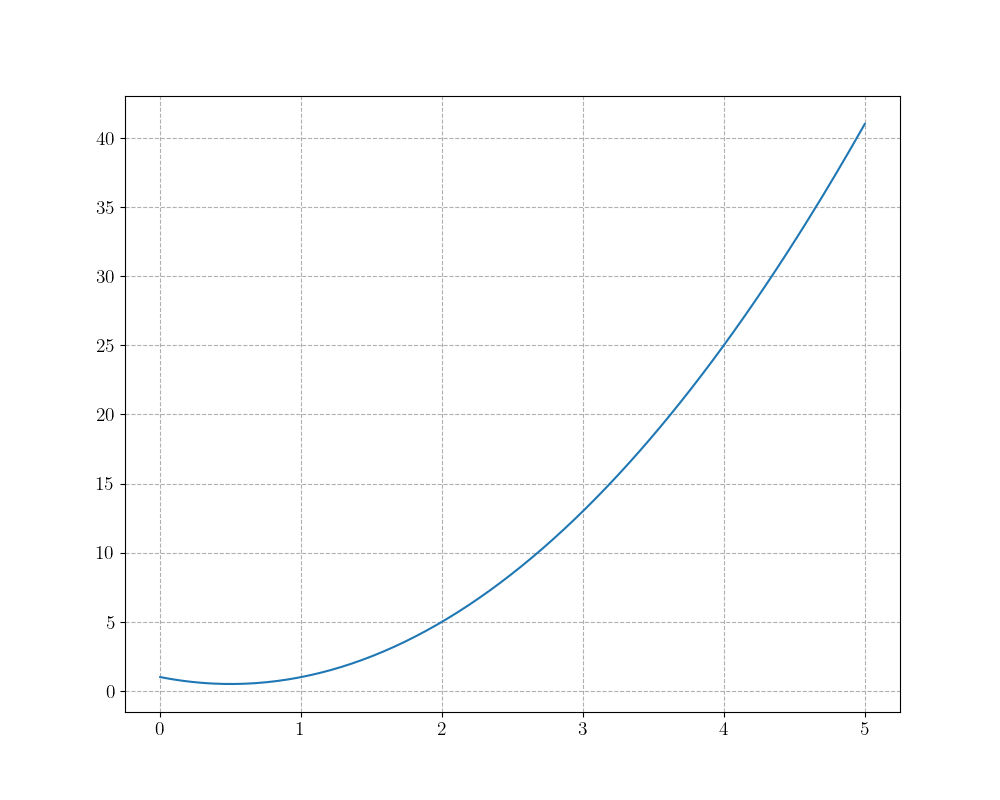

In [12]:
#params = {'C_0':10, 'C_2':3, 'C_3':-0.5}
params = {'C_0':1, 'C_1':-2, 'C_2':2}
xs = np.linspace(0, 5, 200)
ys = ndeg_poly(xs, **params)

fig, ax = plt.subplots()
ax.plot(xs, ys)

In [3]:
len(results_hall_nmr[0].params), len(results_hall_nmr[3].params)

(3, 2)

In [4]:
results_hall[6]

In [31]:
for key, val in sorted(results_hall.items()):
    print(f'run {key}: {val.params["B"]}')

run 0: <Parameter 'B', value=-7.204317289152536e-05 +/- 4.67e-06, bounds=[-inf:inf]>
run 1: <Parameter 'B', value=-0.000143592934465818 +/- 1.24e-05, bounds=[-inf:inf]>
run 2: <Parameter 'B', value=-0.00012831268343408634 +/- 7.06e-06, bounds=[-inf:inf]>
run 3: <Parameter 'B', value=-7.599424453182596e-06 +/- 6.57e-06, bounds=[-inf:inf]>
run 4: <Parameter 'B', value=-9.928510574945364e-06 +/- 1.54e-05, bounds=[-inf:inf]>
run 5: <Parameter 'B', value=-1.0362295692114762e-05 +/- 0.000116, bounds=[-inf:inf]>
run 6: <Parameter 'B', value=2.7065103822717512e-05 +/- 2.65e-05, bounds=[-inf:inf]>
run 7: <Parameter 'B', value=3.0999427126469914e-07 +/- 5.62e-05, bounds=[-inf:inf]>
run 8: <Parameter 'B', value=-1.2997503204482258e-05 +/- 2.53e-05, bounds=[-inf:inf]>
run 9: <Parameter 'B', value=1.7742075515168182e-05 +/- 7.45e-05, bounds=[-inf:inf]>
run 10: <Parameter 'B', value=-2.0893454166534182e-05 +/- 2.09e-05, bounds=[-inf:inf]>
run 11: <Parameter 'B', value=-0.00013444854904922678 +/- 9.8

In [32]:
# extra dfs
df = pd.read_pickle(pklproc)

In [33]:
df_ = df.query('run_num == 10')

In [34]:
params = lm.Parameters()
params.add('A', value=0, vary=True)

In [35]:
params['A'].vary = False

In [36]:
params['A']

<Parameter 'A', value=0 (fixed), bounds=[-inf:inf]>

<IPython.core.display.Javascript object>


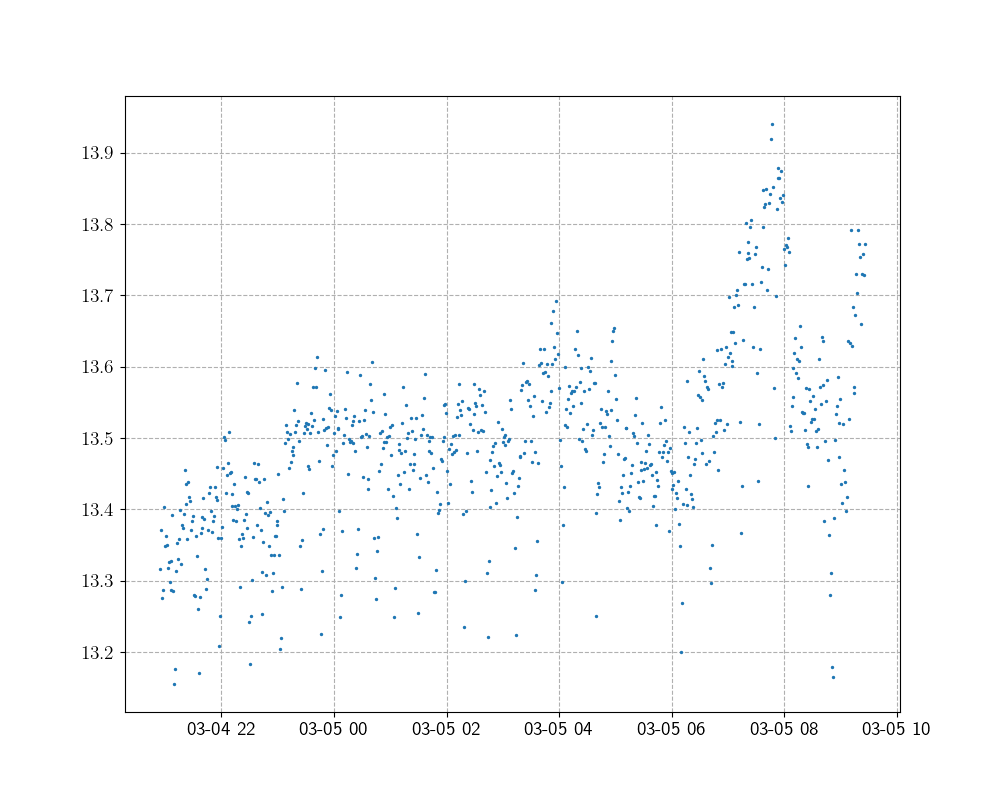

In [37]:
y = 'LCW in barrel'
fig, ax = plt.subplots()

ax.scatter(df_.index, df_[y], s=2)

In [38]:
6e-4 * 8e-3

4.8e-06

In [39]:
def lin_plus_unc(x, result):
    y0 = mod_lin(x, **result.params)
    cov = result.covar
    yerr = (x**2 * cov[1,1] + cov[0,0] + 2 * x * cov[0,1])**(1/2)
    return y0, yerr

def lin_plus_unc_old(x, result):
    y0 = mod_lin(x, **result.params)
    p_m = {'A':result.params['A'].value-result.params['A'].stderr, 'B':result.params['B']-result.params['B'].stderr}
    p_p = {'A':result.params['A'].value+result.params['A'].stderr, 'B':result.params['B']+result.params['B'].stderr}
    y_m = mod_lin(x, **p_m)
    y_p = mod_lin(x, **p_p)
    return y0, y_m-y0, y_p-y0

In [40]:
T0 = 15
for i,result in results_nmr.items():
    #if (3 <= i <= 18):
    if (7 <= i <= 18):
        print(lin_plus_unc(T0, result), end='')
        print(lin_plus_unc_old(T0, result))

(0.7339904181558112, 3.744912817890966e-06)(0.7339904181558112, -5.285607802196779e-05, 5.285607802207881e-05)
(0.8224100114095682, 1.3034996223042227e-06)(0.8224100114095682, -2.402031306791841e-05, 2.402031306791841e-05)
(0.9066650569424834, 2.928048576102843e-06)(0.9066650569424834, -7.160146201468098e-05, 7.1601462014792e-05)
(0.9839258161145357, 4.6990438260968056e-07)(0.9839258161145357, -2.046419311985126e-05, 2.0464193119962282e-05)
(1.0513718723676746, 1.0100941690920784e-06)(1.0513718723676746, -9.77419532290913e-05, 9.774195322886925e-05)
(1.0504595525603153, 6.09440293307569e-07)(1.0504595525603153, -7.19584278541241e-06, 7.19584278541241e-06)
(1.1098342378036756, 1.34311190965652e-06)(1.1098342378036756, -1.1050078729368806e-05, 1.1050078729368806e-05)
(1.161996365249929, 5.490585240320771e-06)(1.161996365249929, -3.798135678589887e-05, 3.798135678589887e-05)
(1.2092292499686752, 2.0106204302277266e-06)(1.2092292499686752, -1.1752563159550533e-05, 1.1752563159328488e-05)
(

In [41]:
T0 = 20
for i,result in results_nmr.items():
    #if (3 <= i <= 18):
    if (7 <= i <= 18):
        print(lin_plus_unc(T0, result), end='')
        print(lin_plus_unc_old(T0, result))

(0.733947570541879, 1.3177850038273348e-05)(0.733947570541879, -6.228945775521577e-05, 6.228945775521577e-05)
(0.822366560596935, 5.5236282276324625e-06)(0.822366560596935, -2.8240849378469157e-05, 2.824084937858018e-05)
(0.906536122239806, 1.5348820686796962e-05)(0.906536122239806, -8.402289859743561e-05, 8.402289859743561e-05)
(0.9837238968885857, 3.957424290491439e-06)(0.9837238968885857, -2.395296210444542e-05, 2.395296210444542e-05)
(1.0510976150963918, 1.74635120740196e-05)(1.0510976150963918, -0.00011419982382498972, 0.00011419982382521177)
(1.0501430623026513, 4.942105313695282e-07)(1.0501430623026513, -8.293927011848723e-06, 8.293927011848723e-06)
(1.1094406629811409, 2.7799266138131674e-07)(1.1094406629811409, -1.266797801635633e-05, 1.2667978016134285e-05)
(1.1615678362447481, 1.0135684459255386e-07)(1.1615678362447481, -4.339653814033895e-05, 4.339653814033895e-05)
(1.2087188908999853, 3.884475826269575e-07)(1.2087188908999853, -1.3376263302111724e-05, 1.3376263302111724e-0

In [81]:
results_nmr[0].model(np.array([1,2,3]), **results_nmr[0].params)

TypeError: 'Model' object is not callable

In [82]:
results_nmr[0].eval(x=np.array([1,2,3]))

array([1.21032705, 1.21022771, 1.21012837])

In [79]:
df.sort_values(by=['Time'])

Time  Magnet Current [A]  \
Datetime                                                         
2021-02-24 22:00:38  2/24/2021 10:00:38 PM          240.069580   
2021-02-24 22:01:38  2/24/2021 10:01:38 PM          240.069580   
2021-02-24 22:02:38  2/24/2021 10:02:38 PM          240.069523   
2021-02-24 22:03:39  2/24/2021 10:03:39 PM          240.069580   
2021-02-24 22:04:38  2/24/2021 10:04:38 PM          240.069580   
...                                    ...                 ...   
2021-04-05 08:05:03    4/5/2021 8:05:03 AM          160.047520   
2021-04-05 08:06:03    4/5/2021 8:06:03 AM          160.047463   
2021-04-05 08:07:03    4/5/2021 8:07:03 AM          160.047520   
2021-04-05 08:08:03    4/5/2021 8:08:03 AM          160.047520   
2021-04-05 08:09:07    4/5/2021 8:09:07 AM          160.047520   

                     Magnet Voltage [V]  Coil 1 (new)  Coil 2 (old)  \
Datetime                                                              
2021-02-24 22:00:38           28.569750     29.752773     27.999565   
2021-02-24 22:01:38           28.569617     29.796495     28.015764   
2021-02-24 22:02:38           28.569517     29.763763     28.025114   
2021-02-24 22:03:39           28.569600     29.743931     28.005903   
2021-02-24 22:04:38           28.569633     29.800413     28.005274   
...                                 ...           ...           ...   
2021-04-05 08:05:03           18.885693     26.896858     26.822971   
2021-04-05 08:06:03           18.885840     26.895796     26.856619   
2021-04-05 08:07:03           18.885925     26.894203     26.892708   
2021-04-05 08:08:03           18.886000     26.904926     26.874367   
2021-04-05 08:09:07           18.885975     26.888575     26.857603   

                     LCW in Coil1  LCW out Coil 1  LCW in Coil 2  \
Datetime                                                           
2021-02-24 22:00:38      7.072250       10.016226      10.939597   
2021-02-24 22:01:38      7.076534       10.007160      10.914255   
2021-02-24 22:02:38      7.088936       10.022373      10.922892   
2021-02-24 22:03:39      7.083243       10.027366      10.945962   
2021-02-24 22:04:38      7.069022       10.009706      10.898451   
...                           ...             ...            ...   
2021-04-05 08:05:03     16.732733       18.459539      18.649643   
2021-04-05 08:06:03     16.735105       18.453161      18.628620   
2021-04-05 08:07:03     16.730320       18.454494      18.626814   
2021-04-05 08:08:03     16.733183       18.459146      18.633291   
2021-04-05 08:09:07     16.715254       18.443857      18.633566   

                     LCW out Coil 2       Yoke  ...  \
Datetime                                        ...   
2021-02-24 22:00:38       13.152507  16.256912  ...   
2021-02-24 22:01:38       13.150097  16.257442  ...   
2021-02-24 22:02:38       13.154957  16.253204  ...   
2021-02-24 22:03:39       13.158072  16.252871  ...   
2021-02-24 22:04:38       13.151645  16.258638  ...   
...                             ...        ...  ...   
2021-04-05 08:05:03       21.047083  18.768127  ...   
2021-04-05 08:06:03       21.054861  18.767283  ...   
2021-04-05 08:07:03       21.064997  18.768127  ...   
2021-04-05 08:08:03       21.063191  18.767734  ...   
2021-04-05 08:09:07       21.040443  18.765751  ...   

                     C90000000D53983A_Cal_Theta  C90000000D53983A_Cal_Phi  \
Datetime                                                                    
2021-02-24 22:00:38                    0.646817                  0.466375   
2021-02-24 22:01:38                    0.644183                  0.460745   
2021-02-24 22:02:38                    0.649952                  0.481235   
2021-02-24 22:03:39                    0.671642                  0.511989   
2021-02-24 22:04:38                    0.643569                  0.471281   
...                                         ...                       ...   
2021-04-05 08:05:03                   

In [77]:
type(results_nmr[0]) == lm.model.ModelResult

True

In [43]:
results_nmr[0].covar[0,1]

-4.063412929254772e-13

In [44]:
results_nmr[0].covar

array([[ 6.81239223e-12, -4.06341293e-13],
       [-4.06341293e-13,  2.42399964e-14]])

In [45]:
2.61**2

6.812099999999999

In [46]:
1e-6**2

1e-12

In [47]:
(results_nmr[0].covar[1,1])**(1/2)

1.556919920438774e-07

# Factory Function

In [90]:
model = lm.Model(mod_lin, independent_vars=['x'])

In [94]:
model.name[6:-1]

'mod_lin'

In [ ]:
# Hall probe

In [70]:
len(results_hall_nmr[0].params), len(results_hall_nmr[3].params)

(3, 2)

In [89]:
results_hall_nmr[0].model.name, results_hall_nmr[3].model.name

('Model(mod_lin_alt)', 'Model(mod_lin)')

In [66]:
def get_Hall_B_at_T0_func(results_hall_nmr, results_nmr):
    # results can be a dictionary from either NMR or Hall
    # temperature regression containing lmfit results
    def lin_plus_unc_hall(T0, run_num):
        x = T0 # redefinition
        params = results_hall_nmr[run_num].params
        params_nmr = results_nmr[run_num].params
        cov = results_hall_nmr[run_num].covar
        cov_nmr = results_nmr[run_num].covar
        #if len(params) == 2:
        if results_hall_nmr[run_num].model.name[6:-1] == 'mod_lin':
            # linear model
            # model calculation at T0
            y0 = mod_lin(x, **params)
            # error propagation
            yerr = (x**2 * cov[1,1] + cov[0,0] + 2 * x * cov[0,1])**(1/2)
        # else mod_lin_alt
        else:
            # alternate linear model
            y0 = mod_lin_alt(x, **params)
            yerr = (x**2 * cov_nmr[1,1] + cov_nmr[0,0] + 2 * x * cov_nmr[0,1] + cov[0,0])**(1/2)
        return y0, yerr
    return lin_plus_unc_hall

In [9]:
get_Hall = get_Hall_B_at_T0_func(results_hall_nmr, results_nmr)
get_Hall_old = get_NMR_B_at_T0_func(results_hall)

<IPython.core.display.Javascript object>


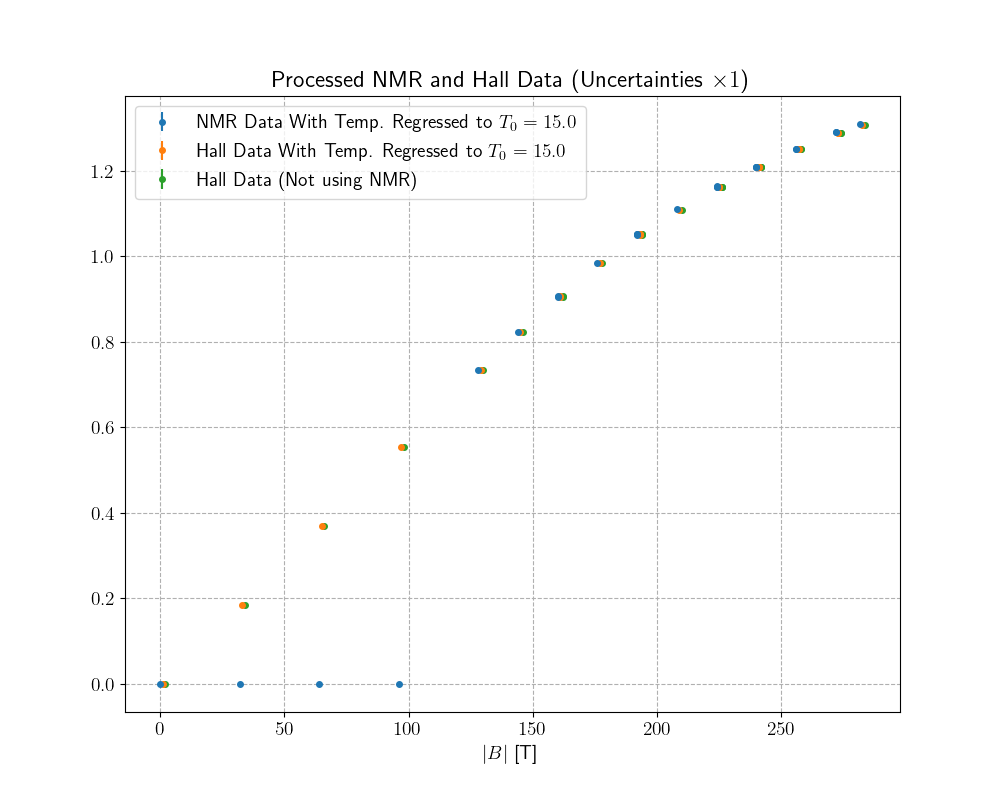

In [22]:
T0 = 15.
fig, ax = plt.subplots()
I = df_info.I.values
NMR_tuples = [get_NMR(T0, i) for i in df_info.index]
NMRs = np.array([i[0] for i in NMR_tuples])
NMR_errs = np.array([i[1] for i in NMR_tuples])
Hall_tuples = [get_Hall(T0, i) for i in df_info.index]
Halls = np.array([i[0] for i in Hall_tuples])
Hall_errs = np.array([i[1] for i in Hall_tuples])
Hall_old_tuples = [get_Hall_old(T0, i) for i in df_info.index]
Hall_olds = np.array([i[0] for i in Hall_old_tuples])
Hall_old_errs = np.array([i[1] for i in Hall_old_tuples])

sf = 1
#sf = 1e4
#sf = 1e3

ax.errorbar(I, NMRs, yerr=sf*NMR_errs, fmt='o', ls='none', ms=4, zorder=100,
            label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
ax.errorbar(I+1, Halls, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, zorder=99,
            label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')
ax.errorbar(I+2, Hall_olds, yerr=sf*Hall_old_errs, fmt='o', ls='none', ms=4, zorder=98,
            label=rf'Hall Data (Not using NMR)')
#ax.errorbar(I+1, Halls-Hall_olds, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, zorder=99,
#             label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')


#ax.set_ylim([-0.5, 2])
#ax.set_ylim([-0.1, 1.5])

ax.set_xlabel('Magnet Current [A]')
ax.set_xlabel(r'$|B|$ [T]')
ax.set_title(rf'Processed NMR and Hall Data (Uncertainties $\times {int(sf):0d}$)')
ax.legend().set_zorder(101);

<IPython.core.display.Javascript object>


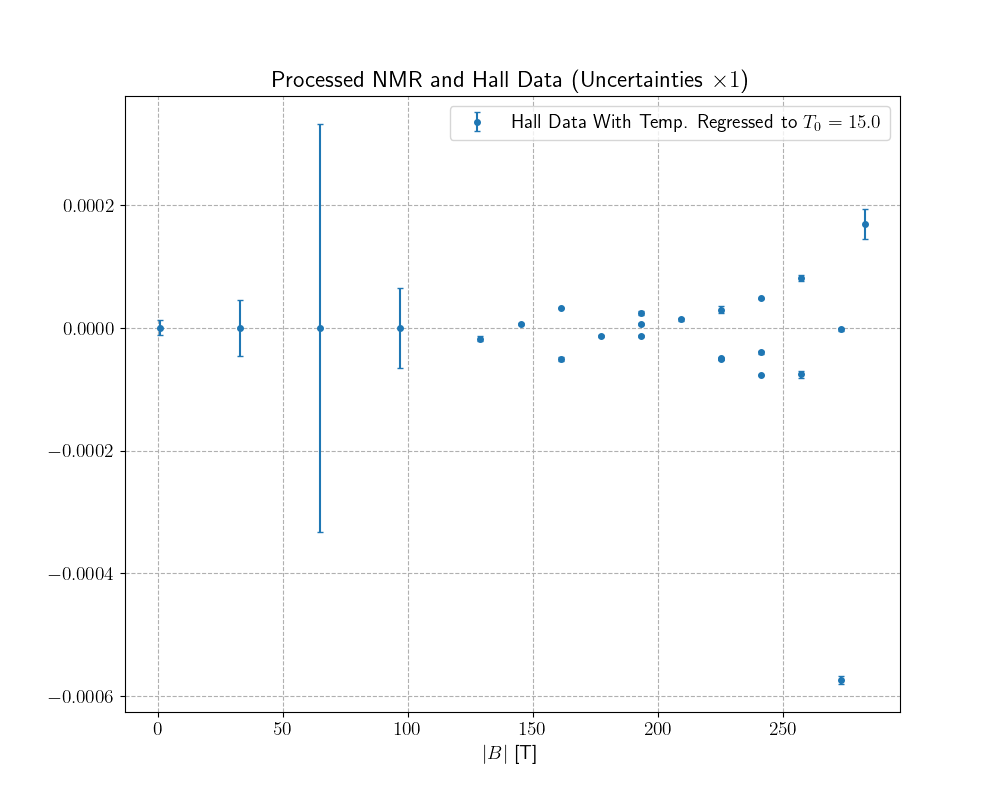

In [24]:
fig, ax = plt.subplots()

sf = 1
#sf = 1e4
#sf = 1e3

# ax.errorbar(I, NMRs, yerr=sf*NMR_errs, fmt='o', ls='none', ms=4, zorder=100,
#             label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
# ax.errorbar(I+1, Halls, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, zorder=99,
#             label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')
# ax.errorbar(I+2, Hall_olds, yerr=sf*Hall_old_errs, fmt='o', ls='none', ms=4, zorder=98,
#             label=rf'Hall Data (Not using NMR)')
ax.errorbar(I+1, Halls-Hall_olds, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, zorder=99,
             label=rf'Hall Data With Temp. Regressed to $T_0={T0}$',
               capsize=2)


#ax.set_ylim([-0.5, 2])
#ax.set_ylim([-0.1, 1.5])

ax.set_xlabel('Magnet Current [A]')
ax.set_xlabel(r'$|B|$ [T]')
ax.set_title(rf'Processed NMR and Hall Data (Uncertainties $\times {int(sf):0d}$)')
ax.legend().set_zorder(101);

In [23]:
Hall_errs

array([8.86540624e-07, 9.75115992e-07, 6.80371572e-07, 1.20676694e-05,
       4.54576188e-05, 3.32272461e-04, 6.55705988e-05, 4.26531634e-06,
       1.71777737e-06, 3.59174957e-06, 1.19068864e-06, 3.09712143e-06,
       1.76032687e-06, 1.76847482e-06, 5.85939721e-06, 2.31565491e-06,
       5.59440216e-06, 2.45397583e-06, 2.37617948e-05, 6.79084509e-06,
       4.66444498e-06, 8.90309480e-07, 1.41318768e-06, 1.83026549e-07])

In [85]:
I

array([2.40069467e+02, 2.24065923e+02, 2.40069009e+02, 8.50279556e-04,
       3.20110056e+01, 6.40217106e+01, 9.60287455e+01, 1.28038948e+02,
       1.44044132e+02, 1.60047885e+02, 1.76051258e+02, 1.92056063e+02,
       1.92056237e+02, 2.08060745e+02, 2.24065366e+02, 2.40068824e+02,
       2.56071131e+02, 2.72075589e+02, 2.81677455e+02, 2.72075324e+02,
       2.56070678e+02, 2.24064884e+02, 1.92055609e+02, 1.60047416e+02])

In [76]:
Halls

array([1.20820851e+00, 1.16319913e+00, 1.20789778e+00, 9.03266818e-04,
       1.84313565e-01, 3.69930982e-01, 5.53525332e-01, 7.33965311e-01,
       8.22365377e-01, 9.06590698e-01, 9.83805736e-01, 1.05116440e+00,
       1.05023854e+00, 1.10946241e+00, 1.16146119e+00, 1.20849013e+00,
       1.25097547e+00, 1.28864678e+00, 1.30810386e+00, 1.28859869e+00,
       1.25107489e+00, 1.16154432e+00, 1.05111456e+00, 9.05913614e-01])

In [77]:
Hall_errs

array([8.86540624e-07, 9.75115992e-07, 6.80371572e-07, 1.20676694e-05,
       4.54576188e-05, 3.32272461e-04, 6.55705988e-05, 4.26531634e-06,
       1.71777737e-06, 3.59174957e-06, 1.19068864e-06, 3.09712143e-06,
       1.76032687e-06, 1.76847482e-06, 5.85939721e-06, 2.31565491e-06,
       5.59440216e-06, 2.45397583e-06, 2.37617948e-05, 6.79084509e-06,
       4.66444498e-06, 8.90309480e-07, 1.41318768e-06, 1.83026549e-07])

In [ ]:
# NMR

In [48]:
def get_T0_func(results):
    # results can be a dictionary from either NMR or Hall temperature regression
    def lin_plus_unc(T0, run_num):
        x = T0 # redefinition
        # model calculation at T0
        y0 = mod_lin(x, **results[run_num].params)
        # error propagation
        cov = results[run_num].covar
        yerr = (x**2 * cov[1,1] + cov[0,0] + 2 * x * cov[0,1])**(1/2)
        return y0, yerr
    return lin_plus_unc

In [49]:
get_NMR = get_T0_func(results_nmr)

In [50]:
# example for looking at hysteresis
get_NMR(15, 0), get_NMR(15, 2)

((1.2089363059212448, 2.7595765939920406e-07),
 (1.2086169146919337, 4.770863649341329e-07))

In [51]:
# water chiller out
get_NMR(15, 11), get_NMR(15, 12)

((1.0513718723676746, 1.0100941690920784e-06),
 (1.0504595525603153, 6.09440293307569e-07))

In [52]:
df_info.columns

Index(['t0', 'tf', 'ramp', 'hyst', 'adc', 'chiller', 'NMR', 'B_NMR', 'I',
       'hours_data', 'num_meas'],
      dtype='object')

In [53]:
df_info.I

0     240.069467
1     224.065923
2     240.069009
3       0.000850
4      32.011006
5      64.021711
6      96.028746
7     128.038948
8     144.044132
9     160.047885
10    176.051258
11    192.056063
12    192.056237
13    208.060745
14    224.065366
15    240.068824
16    256.071131
17    272.075589
18    281.677455
19    272.075324
20    256.070678
21    224.064884
22    192.055609
23    160.047416
Name: I, dtype: float64

<IPython.core.display.Javascript object>


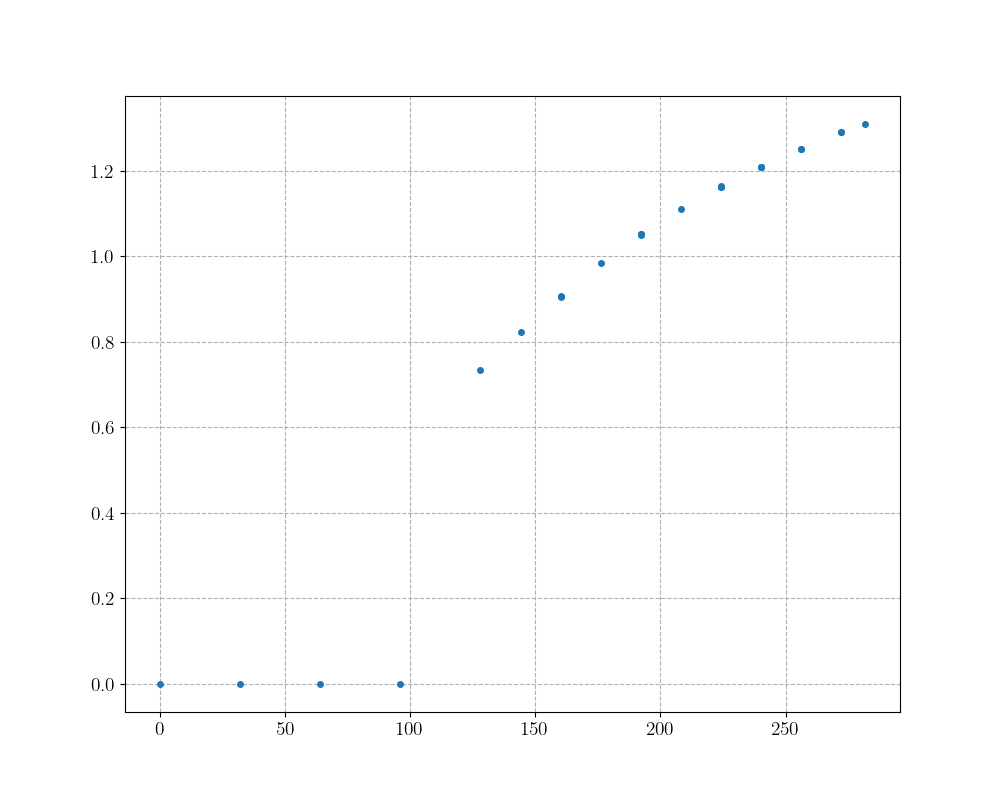

NameError: name 'Halls' is not defined

In [74]:
T0 = 15.
fig, ax = plt.subplots()
I = df_info.I.values
NMR_tuples = [get_NMR(T0, i) for i in df_info.index]
NMRs = np.array([i[0] for i in NMR_tuples])
NMR_errs = np.array([i[1] for i in NMR_tuples])

ax.errorbar(I, NMRs, yerr=NMR_errs, fmt='o', ls='none', ms=4, label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
ax.errorbar(I, Halls, yerr=Hall_errs, fmt='o', ls='none', ms=4, label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')

ax.set_xlabel('Magnet Current [A]')
ax.set_xlabel(r'$|B|$ [T]')
ax.legend();

In [55]:
I, NMRs, NMR_errs

(array([2.40069467e+02, 2.24065923e+02, 2.40069009e+02, 8.50279556e-04,
        3.20110056e+01, 6.40217106e+01, 9.60287455e+01, 1.28038948e+02,
        1.44044132e+02, 1.60047885e+02, 1.76051258e+02, 1.92056063e+02,
        1.92056237e+02, 2.08060745e+02, 2.24065366e+02, 2.40068824e+02,
        2.56071131e+02, 2.72075589e+02, 2.81677455e+02, 2.72075324e+02,
        2.56070678e+02, 2.24064884e+02, 1.92055609e+02, 1.60047416e+02]),
 array([1.20893631, 1.16365581, 1.20861691, 0.        , 0.        ,
        0.        , 0.        , 0.73399042, 0.82241001, 0.90666506,
        0.98392582, 1.05137187, 1.05045955, 1.10983424, 1.16199637,
        1.20922925, 1.25193369, 1.28984014, 1.30942059, 1.28977017,
        1.25201054, 1.16205604, 1.05135218, 0.90600039]),
 array([2.75957659e-07, 5.02631886e-07, 4.77086365e-07, 4.02255610e-07,
        1.51506173e-06, 1.10691823e-05, 2.18561415e-06, 3.74491282e-06,
        1.30349962e-06, 2.92804858e-06, 4.69904383e-07, 1.01009417e-06,
        6.09440293e-

In [56]:
df

Time  Magnet Current [A]  \
Datetime                                                        
2021-02-24 13:28:38  2/24/2021 1:28:38 PM          240.069750   
2021-02-24 13:29:38  2/24/2021 1:29:38 PM          240.069580   
2021-02-24 13:30:38  2/24/2021 1:30:38 PM          240.069580   
2021-02-24 13:31:39  2/24/2021 1:31:39 PM          240.069580   
2021-02-24 13:32:37  2/24/2021 1:32:37 PM          240.069693   
...                                   ...                 ...   
2021-04-05 08:05:03   4/5/2021 8:05:03 AM          160.047520   
2021-04-05 08:06:03   4/5/2021 8:06:03 AM          160.047463   
2021-04-05 08:07:03   4/5/2021 8:07:03 AM          160.047520   
2021-04-05 08:08:03   4/5/2021 8:08:03 AM          160.047520   
2021-04-05 08:09:07   4/5/2021 8:09:07 AM          160.047520   

                     Magnet Voltage [V]  Coil 1 (new)  Coil 2 (old)  \
Datetime                                                              
2021-02-24 13:28:38           28.571600     29.840097     28.007162   
2021-02-24 13:29:38           28.571800     29.787987     28.031197   
2021-02-24 13:30:38           28.571950     29.807564     28.020391   
2021-02-24 13:31:39           28.572000     29.803446     28.041353   
2021-02-24 13:32:37           28.572150     29.791532     28.036276   
...                                 ...           ...           ...   
2021-04-05 08:05:03           18.885693     26.896858     26.822971   
2021-04-05 08:06:03           18.885840     26.895796     26.856619   
2021-04-05 08:07:03           18.885925     26.894203     26.892708   
2021-04-05 08:08:03           18.886000     26.904926     26.874367   
2021-04-05 08:09:07           18.885975     26.888575     26.857603   

                     LCW in Coil1  LCW out Coil 1  LCW in Coil 2  \
Datetime                                                           
2021-02-24 13:28:38      7.107207       10.018359      10.879767   
2021-02-24 13:29:38      7.115325       10.044732      10.914607   
2021-02-24 13:30:38      7.117673       10.037371      10.909006   
2021-02-24 13:31:39      7.122602       10.033122      10.869917   
2021-02-24 13:32:37      7.136472       10.048101      10.879786   
...                           ...             ...            ...   
2021-04-05 08:05:03     16.732733       18.459539      18.649643   
2021-04-05 08:06:03     16.735105       18.453161      18.628620   
2021-04-05 08:07:03     16.730320       18.454494      18.626814   
2021-04-05 08:08:03     16.733183       18.459146      18.633291   
2021-04-05 08:09:07     16.715254       18.443857      18.633566   

                     LCW out Coil 2       Yoke  ...  \
Datetime                                        ...   
2021-02-24 13:28:38       13.184784  15.563291  ...   
2021-02-24 13:29:38       13.178277  15.564605  ...   
2021-02-24 13:30:38       13.181531  15.567900  ...   
2021-02-24 13:31:39       13.189683  15.573018  ...   
2021-02-24 13:32:37       13.194210  15.577725  ...   
...                             ...        ...  ...   
2021-04-05 08:05:03       21.047083  18.768127  ...   
2021-04-05 08:06:03       21.054861  18.767283  ...   
2021-04-05 08:07:03       21.064997  18.768127  ...   
2021-04-05 08:08:03       21.063191  18.767734  ...   
2021-04-05 08:09:07       21.040443  18.765751  ...   

                     C90000000D53983A_Cal_Theta  C90000000D53983A_Cal_Phi  \
Datetime                                                                    
2021-02-24 13:28:38                    0.634256                  0.461928   
2021-02-24 13:29:38                    0.639018                  0.478226   
2021-02-24 13:30:38                    0.643944                  0.480042   
2021-02-24 13:31:39                    0.654508                  0.476417   
2021-02-24 13:32:37                    0.645205                  0.429792   
...                                         ...                       ...   
2021-04-05 08:05:03                    0.970517   

In [57]:
param_Bs = np.array([result.params['B'].value for key, result in sorted(results_nmr.items())])
param_Bs

array([-9.93390540e-05, -1.00993925e-04, -9.03672879e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -8.56952279e-06,
       -8.69016253e-06, -2.57869405e-05, -4.03838452e-05, -5.48514543e-05,
       -6.32980515e-05, -7.87149645e-05, -8.57058010e-05, -1.02071814e-04,
       -1.18368166e-04, -1.49660849e-04, -1.13862048e-04, -1.47258860e-04,
       -1.41849063e-04, -1.20681798e-04, -9.76612417e-05, -5.47877745e-05])

In [64]:
param_Berrs = np.array([result.params['B'].stderr for key, result in sorted(results_nmr.items())])
param_Berrs

array([1.55691992e-07, 4.14887879e-07, 2.35315686e-07, 2.19012343e-07,
       5.12622602e-07, 3.86023332e-06, 8.83427694e-07, 1.88667595e-06,
       8.44107262e-07, 2.48428732e-06, 6.97753797e-07, 3.29157412e-06,
       2.19616845e-07, 3.23579857e-07, 1.08303627e-06, 3.24740029e-07,
       7.15860969e-07, 2.41918064e-07, 2.41234991e-06, 7.17906710e-07,
       5.26767030e-07, 1.21888091e-07, 1.98844662e-07, 1.37909429e-08])

In [58]:
param_Bs / NMRs

<ipython-input-58-77fe00a7309c>:1: RuntimeWarning: invalid value encountered in true_divide
  param_Bs / NMRs


array([-8.21706268e-05, -8.67902041e-05, -7.47691736e-05,             nan,
                   nan,             nan,             nan, -1.16752516e-05,
       -1.05667032e-05, -2.84415290e-05, -4.10435874e-05, -5.21713161e-05,
       -6.02574858e-05, -7.09249740e-05, -7.37573745e-05, -8.44106390e-05,
       -9.45482713e-05, -1.16030541e-04, -8.69560542e-05, -1.14174497e-04,
       -1.13297021e-04, -1.03851961e-04, -9.28910824e-05, -6.04721311e-05])

<IPython.core.display.Javascript object>


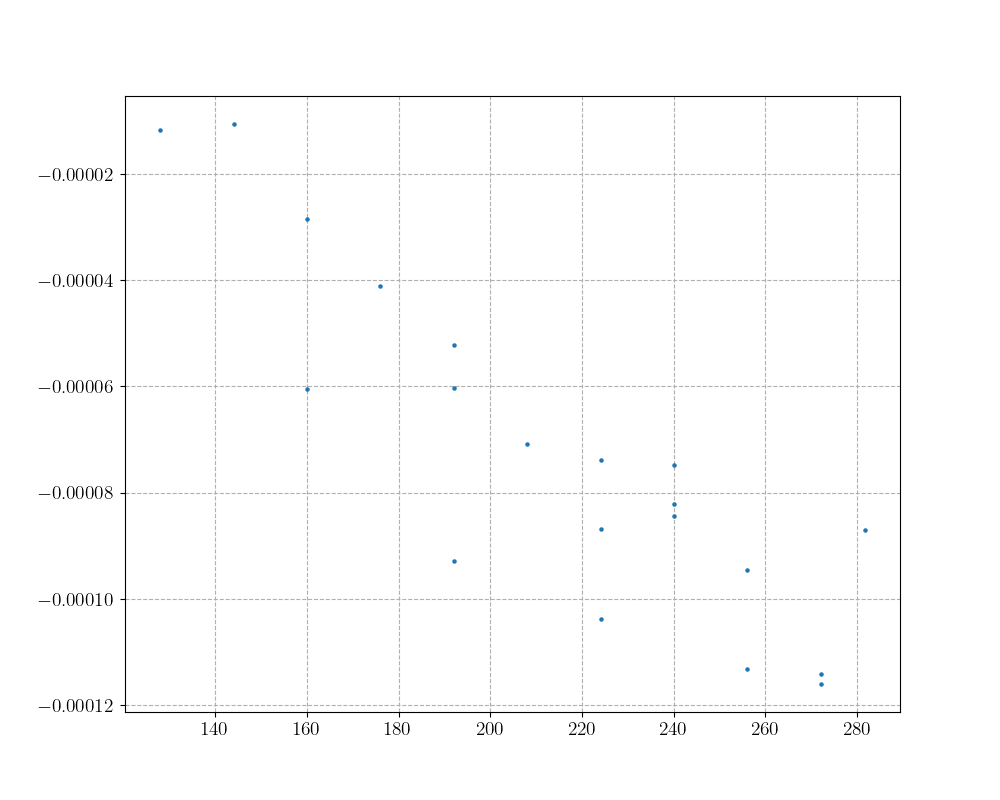

<ipython-input-59-55d4bd3a70d2>:2: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter(I, param_Bs/NMRs, s=5)


In [59]:
fig, ax = plt.subplots()
ax.scatter(I, param_Bs/NMRs, s=5)

In [60]:
df_info.ramp.values

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False])

In [63]:
param_Bs

array([-9.93390540e-05, -1.00993925e-04, -9.03672879e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -8.56952279e-06,
       -8.69016253e-06, -2.57869405e-05, -4.03838452e-05, -5.48514543e-05,
       -6.32980515e-05, -7.87149645e-05, -8.57058010e-05, -1.02071814e-04,
       -1.18368166e-04, -1.49660849e-04, -1.13862048e-04, -1.47258860e-04,
       -1.41849063e-04, -1.20681798e-04, -9.76612417e-05, -5.47877745e-05])

<IPython.core.display.Javascript object>


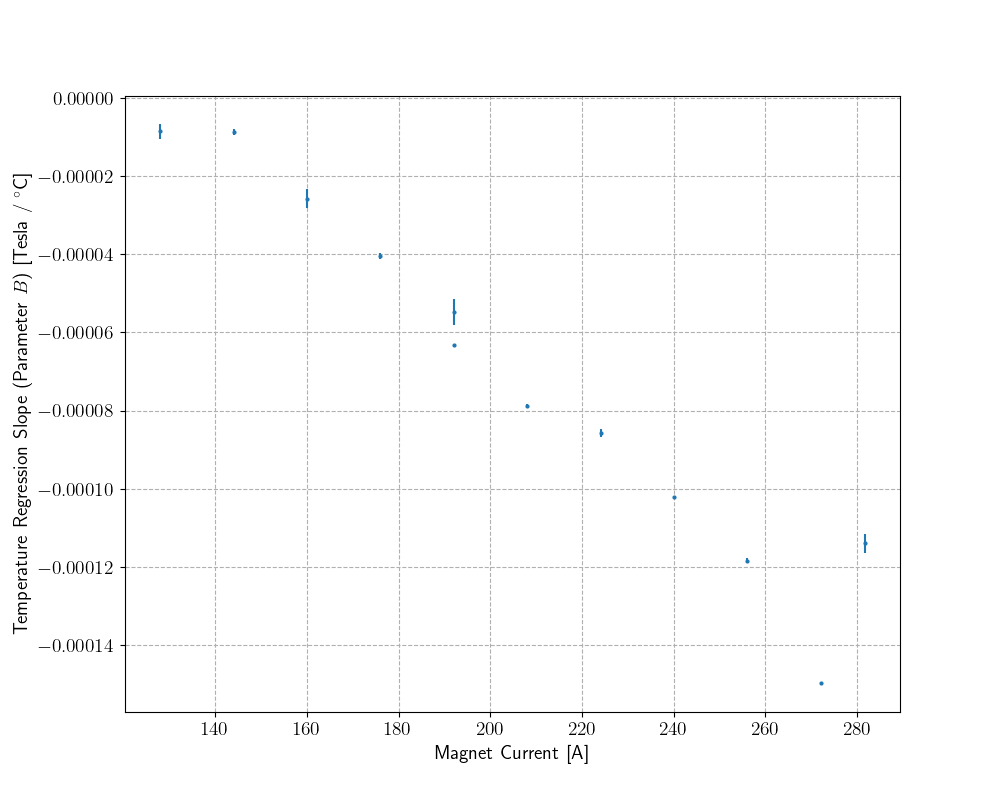

Text(0, 0.5, 'Temperature Regression Slope (Parameter $B$) [Tesla / $^\\circ$C]')

In [67]:
# MAKE NICE VERSION
m = (df_info.ramp.values) & (df_info.NMR.values)
fig, ax = plt.subplots()
#ax.scatter(I[m], param_Bs[m], s=10)
ax.errorbar(I[m], param_Bs[m], yerr=param_Berrs[m], fmt='o', ls='none', ms=2, zorder=99)
ax.set_xlabel('Magnet Current [A]')
#ax.set_ylabel(r'$|B|_{\mathrm{Hall}}/|B|_{\mathrm{NMR}}$')
ax.set_ylabel(r'Temperature Regression Slope (Parameter $B$) [Tesla / $^\circ$C]')

# Load Factory Function From Script

In [71]:
from factory_funcs import get_NMR_B_at_T0_func, get_Hall_B_at_T0_func

In [5]:
get_NMR = get_NMR_B_at_T0_func(results_nmr)
get_Hall = get_Hall_B_at_T0_func(results_hall_nmr, results_nmr)

<IPython.core.display.Javascript object>


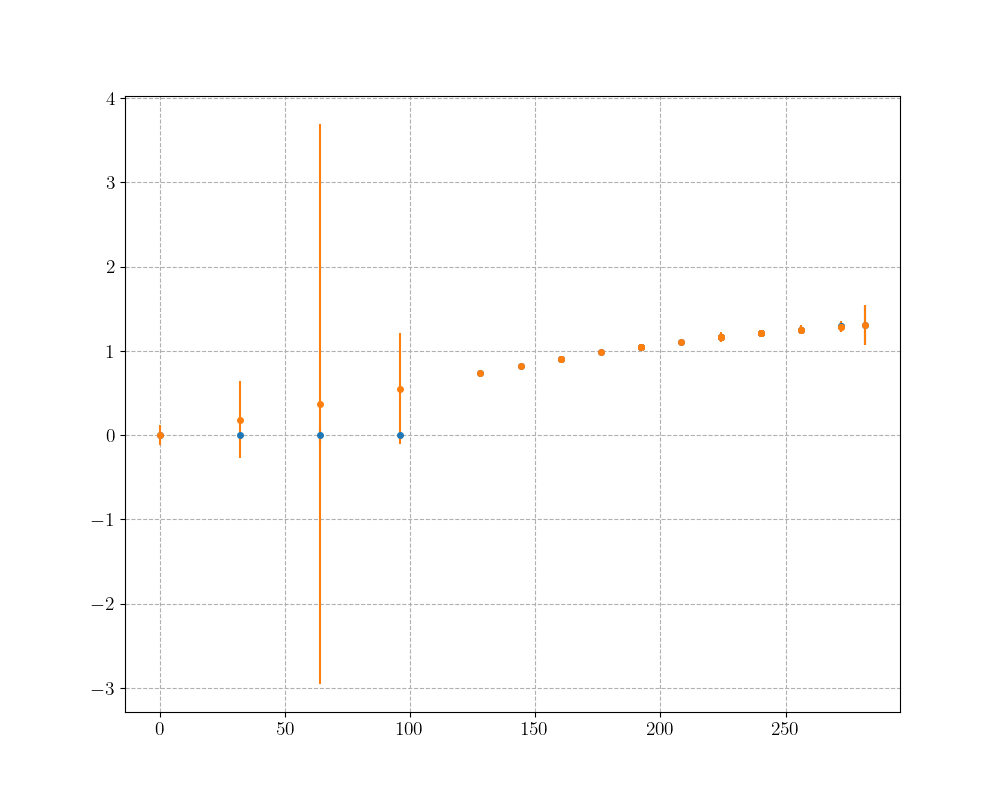

<ErrorbarContainer object of 3 artists>

In [8]:
T0 = 15.
fig, ax = plt.subplots()
I = df_info.I.values
NMR_tuples = [get_NMR(T0, i) for i in df_info.index]
NMRs = np.array([i[0] for i in NMR_tuples])
NMR_errs = np.array([i[1] for i in NMR_tuples])
Hall_tuples = [get_Hall(T0, i) for i in df_info.index]
Halls = np.array([i[0] for i in Hall_tuples])
Hall_errs = np.array([i[1] for i in Hall_tuples])

sf = 1e4
#sf = 1

ax.errorbar(I, NMRs, yerr=sf*NMR_errs, fmt='o', ls='none', ms=4, label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
ax.errorbar(I, Halls, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')

In [22]:
I_all = df['Magnet Current [A]'].values
ratio_all = df[f'{probe}_Cal_Bmag']/df['NMR [T]'].values

<IPython.core.display.Javascript object>


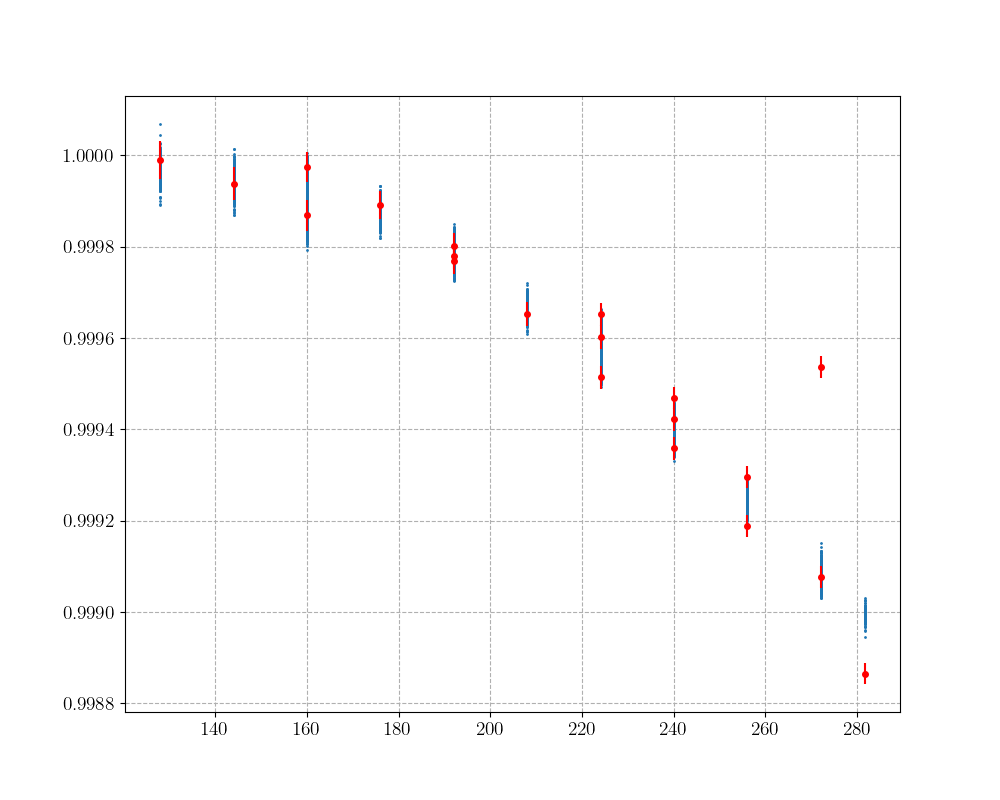

<ipython-input-27-b0d3c0fedd34>:11: RuntimeWarning: divide by zero encountered in true_divide
  Rs = Halls/NMRs
<ipython-input-27-b0d3c0fedd34>:12: RuntimeWarning: divide by zero encountered in true_divide
  sigma_Rs = Rs * ((3e-5/Halls)**2 + (1e-6/NMRs)**2)**(1/2)


<ErrorbarContainer object of 3 artists>

In [27]:
T0 = 15.
fig, ax = plt.subplots()
I = df_info.I.values
NMR_tuples = [get_NMR(T0, i) for i in df_info.index]
NMRs = np.array([i[0] for i in NMR_tuples])
NMR_errs = np.array([i[1] for i in NMR_tuples])
Hall_tuples = [get_Hall(T0, i) for i in df_info.index]
Halls = np.array([i[0] for i in Hall_tuples])
Hall_errs = np.array([i[1] for i in Hall_tuples])

Rs = Halls/NMRs
sigma_Rs = Rs * ((3e-5/Halls)**2 + (1e-6/NMRs)**2)**(1/2)

ax.scatter(I_all, ratio_all, s=1, zorder=99)
##ax.scatter(I, Halls/NMRs, zorder=100)
ax.errorbar(I, Rs, yerr=sigma_Rs, fmt='o', color='red', ls='none', ms=4,
            label=rf'Hall/NMR Data With Temp. Regressed to $T_0={T0}$', zorder=100)
#ax.errorbar(I, NMRs, yerr=NMR_errs, fmt='o', ls='none', ms=4, label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
#ax.errorbar(I, Halls, yerr=Hall_errs, fmt='o', ls='none', ms=4, label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')